<a href="https://colab.research.google.com/github/daniel84101/Comparing-the-Performance-of-Causal-Deep-Neural-Networks/blob/main/DAT_603_230818.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [314]:
import pandas as pd
from datetime import datetime
import json
from sklearn.preprocessing import MultiLabelBinarizer
from functools import reduce
import scipy.stats
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import Dataset

In [315]:
dtype = {'UId':str,
         'usage_purpose':str,
         'location':str,
         'lang': str,
         'country':str,
         'FirstPlatform':str,
         'FirstVersion':str,
         'FirstPlatformViewer':str,
         'FirstVersionViewer':str,
         'reg_time':str,
         'TimeFirstLive':str,
         'TimeFirstLive_s':str,
         'TimeFirstSubscribe':str,
         'click':str,
         'Platform':str,
         'first_show_time':str,
         'second_show_time':str,
         'SessionId':str,
         'second_show_sid':str,
         'click_time':str,
         'two_show_gap':str,
         'time_stay_on_page':str,
         'f0_':str,
         'slc_30m_rev':str,
         'last_online':str,
         'mobile_click':'Int64',
         'alfredcam_click':'Int64',
         'web_click':'Int64',
         'set_later_click':'Int64',
         'slc_30m_scv':'Int64',
         'clc_30m_clcs':'Int64',
         'time_account_first_multi':str,
         'mat_compl': str,
         'mobile_click_1d':'Int64',
         'alfredcam_click_1d':'Int64',
         'web_click_1d':'Int64',
         'set_later_click_1d':'Int64',
         'clc_1d_clcs':'Int64'
         }

df = pd.read_csv('/content/drive/MyDrive/bquxjob_2b2b01f2_18a256c5230.csv', sep=",",
                 dtype=dtype, parse_dates=['reg_time','TimeFirstLive','TimeFirstLive_s','TimeFirstSubscribe','first_show_time',
                                           'second_show_time','click_time','last_online','time_account_first_multi','mat_compl'])


In [316]:
df['location'] = df.location.apply(lambda x: x[1:-1].split(',')).apply(lambda x: [p for p in x if p != ''])

# Checking Data Quality and Pull out the Working Sample

Case 1, Whose first platform != first platform viewer or first platform != select camera shown platform or first platform viewer != select camera shown platform

In [317]:
A = df[((~df['FirstPlatform'].isnull()) & (~df['FirstPlatformViewer'].isnull()) & (~df['Platform'].isnull())) &
   (df['FirstPlatform']==df['FirstPlatformViewer']) & (df['Platform']==df['FirstPlatformViewer'])]['UId']

B = df[((~df['FirstPlatform'].isnull()) & (~df['FirstPlatformViewer'].isnull()) & (~df['Platform'].isnull()))]['UId']

bad = pd.concat([A, B]).drop_duplicates(keep=False)
pd.options.display.max_columns = None

In [318]:
df[df['UId'].isin(bad)]

,UId,usage_purpose,location,lang,country,FirstPlatform,FirstVersion,FirstPlatformViewer,FirstVersionViewer,reg_time,TimeFirstLive,TimeFirstLive_s,TimeFirstSubscribe,click,Platform,first_show_time,second_show_time,SessionId,second_show_sid,click_time,two_show_gap,time_stay_on_page,f0_,slc_30m_rev,last_online,mobile_click,alfredcam_click,web_click,set_later_click,slc_30m_scv,clc_30m_clcs,time_account_first_multi,mat_compl,mobile_click_1d,alfredcam_click_1d,web_click_1d,set_later_click_1d,clc_1d_clcs
65,00acf091,B&K,[],th,TW,IOS,NaN,ANDROID,NaN,2022-08-22 08:10:39,2022-08-22 00:00:00.000,2022-08-22 08:12:09.826001,NaT,add_mobile_device,IOS,2022-08-22 08:10:54.373003,2022-08-25 04:28:26.983036,1661155439,1661400215,2022-08-22 08:11:22.609004,0-0 2 20:17:32.610033,0-0 0 0:0:28.236001,true,1,2022-08-29 06:32:40.452002,1,0,0,0,151,9,2022-08-26 17:31:52,2022-08-22 08:11:38.985000,1,0,0,0,25
149,01f1e542,Unknown,[bedroom],en,US,ANDROID,2022.12.1,IOS,2022.13.0,2022-08-27 23:35:21,2022-08-27 23:38:19.651,2022-08-27 23:38:09.813013,2022-09-13 04:07:25,add_mobile_device,ANDROID,2022-08-27 23:35:30.259001,2022-08-27 23:36:57.803006,1661642773,1661642773,2022-08-27 23:35:48.293001,0-0 0 0:1:27.544005,0-0 0 0:0:18.034,true,2,2022-09-03 22:06:12.769001,2,0,0,0,57,12,NaT,2022-08-27 23:37:58.843000,2,0,0,0,32
177,02564002,Home,[],en,US,ANDROID,2022.12.1,IOS,2022.12.1,2022-08-21 15:12:10,2022-08-21 15:13:28.617,2022-08-21 15:13:20.026020,NaT,set_later,ANDROID,NaT,NaT,NaN,NaN,2022-08-21 15:12:35.024000,NaN,NaN,true,1,2022-08-24 21:41:41.653001,0,0,0,1,34,8,NaT,2022-08-21 15:12:55.190004,0,0,0,1,31
210,02d6e75a,Home,[],en,US,ANDROID,2022.12.1,IOS,2022.12.1,2022-08-24 21:40:01,2022-08-24 21:43:03.807,2022-08-24 21:42:54.229018,NaT,add_mobile_device,ANDROID,2022-08-24 21:40:09.506001,2022-08-24 21:40:16.942004,1661377149,1661377149,2022-08-24 21:40:14.119001,0-0 0 0:0:7.436003,0-0 0 0:0:4.613,NaN,6,2022-08-24 21:45:47.464106,3,0,0,3,54,15,NaT,2022-08-24 21:42:06.596002,3,0,0,3,15
214,02e3214e,B&K,[baby_room],en,US,ANDROID,2022.12.1,IOS,2022.13.0,2022-08-25 21:48:13,2022-08-25 21:49:38.000,2022-08-25 21:49:30.285021,NaT,add_mobile_device,ANDROID,2022-08-25 21:48:30.346001,2022-08-25 22:01:27.595005,1661464031,1661464134,2022-08-25 21:48:37.395001,0-0 0 0:12:57.249004,0-0 0 0:0:7.049,NaN,5,2022-09-01 02:56:07.349007,4,0,0,0,219,52,NaT,2022-08-25 21:49:23.585010,4,0,0,0,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17576,fbc05117,Home,"[back_door, store, driveway, garage, yard, fro...",en,US,IOS,NaN,IOS,NaN,2022-08-22 02:31:58,2022-08-22 00:00:00.000,2022-08-22 03:34:22.338024,NaT,add_mobile_device,ANDROID,NaT,NaT,NaN,NaN,2022-08-22 02:38:12.974015,NaN,NaN,true,5,2022-08-29 02:16:52.051001,2,0,0,0,25,5,2022-08-22 02:37:08,2022-08-22 03:32:53.332007,5,0,0,0,115
17658,fcb84842,Unknown,[bedroom],en,US,WEB,NaN,WEB,NaN,2022-08-22 22:19:40,2022-08-22 22:43:26.479,2022-08-22 22:43:16.576012,NaT,add_mobile_device,ANDROID,2022-08-22 23:59:11.327036,2022-08-22 23:59:28.092040,1661212621,1661212621,2022-08-22 23:59:25.687037,0-0 0 0:0:16.765004,0-0 0 0:0:14.360001,true,2,2022-08-29 11:21:57.229028,1,0,0,1,54,8,2022-08-22 22:19:40,2022-08-22 22:42:49.361003,1,0,0,1,15
17690,fd237e62,Pet,[living_room],en,US,ANDROID,2022.12.1,IOS,2022.13.0,2022-08-25 03:51:18,2022-08-25 03:52:19.393,2022-08-25 03:52:09.438020,NaT,add_mobile_device,ANDROID,2022-08-25 03:51:31.349001,NaT,1661399369,NaN,2022-08-25 03:51:34.848002,NaN,0-0 0 0:0:3.499001,NaN,1,2022-08-31 16:48:35.127001,1,0,0,0,28,10,NaT,2022-08-25 03:51:55.954009,1,0,0,0,40
17696,fd2e30ed,B&K,[],en,US,ANDROID,2022.12.1,IOS,2022.13.0,2022-08-27 10:34:32,2022-08-27 10:38:01.174,2022-08-27 10:37:51.601038,2023-03-09 15:29:19,add_mobile_device,ANDROID,2022-08-27 10:34:40.762001,NaT,1661596395,NaN,2022-08-27 10:34:55.679001,NaN,0-0 0 0:0:14.917,NaN,1,2022-09-03 10:08:56.599001,1,0,0,0,65,10,NaT,2022-08-27 10:35:05.

First platform seems to coincide with select camera shown platform more often. It might be an mechanical issue for First platform != First viewer platform.
(eg. viewer platform were recorded when they finish paring and intriger some process...etc.)

Decision: Drop First viewer platform variable, and keep all the sample


Case 2, further investige when First platform != select camera shown platform

In [319]:
A_2 = df[((~df['FirstPlatform'].isnull()) & (~df['Platform'].isnull())) & (df['Platform']==df['FirstPlatform'])]['UId']

B_2 = df[((~df['FirstPlatform'].isnull()) & (~df['Platform'].isnull()))]['UId']

bad_2 = pd.concat([A_2, B_2]).drop_duplicates(keep=False)
df[df['UId'].isin(bad_2)]

,UId,usage_purpose,location,lang,country,FirstPlatform,FirstVersion,FirstPlatformViewer,FirstVersionViewer,reg_time,TimeFirstLive,TimeFirstLive_s,TimeFirstSubscribe,click,Platform,first_show_time,second_show_time,SessionId,second_show_sid,click_time,two_show_gap,time_stay_on_page,f0_,slc_30m_rev,last_online,mobile_click,alfredcam_click,web_click,set_later_click,slc_30m_scv,clc_30m_clcs,time_account_first_multi,mat_compl,mobile_click_1d,alfredcam_click_1d,web_click_1d,set_later_click_1d,clc_1d_clcs
217,02ee5cd8,Home,[],en,US,WEB,NaN,ANDROID,2022.12.1,2022-08-27 12:02:55,2022-08-27 12:04:46.439,2022-08-27 12:04:36.563011,NaT,add_web_camera,ANDROID,2022-08-27 12:04:06.124002,2022-08-27 12:04:31.303013,1661601760,1661601760,2022-08-27 12:04:14.199006,0-0 0 0:0:25.179011,0-0 0 0:0:8.075004,true,4,2022-08-31 22:49:28.632027,1,0,2,1,78,28,2022-08-27 12:02:55,2022-08-27 12:24:43.585001,1,0,2,1,32
663,08f68a0b,Pet,[],en,US,ANDROID,2022.12.1,IOS,2022.12.1,2022-08-24 11:12:20,2022-08-24 20:39:14.358,2022-08-24 20:39:04.763017,NaT,add_mobile_device,IOS,2022-08-24 20:38:03.887009,NaT,1661373476,NaN,2022-08-24 20:38:10.701010,NaN,0-0 0 0:0:6.814001,NaN,1,2022-08-25 16:12:58.199002,1,0,0,0,20,4,NaT,2022-08-24 11:15:27.102002,1,0,0,0,6
673,09172e72,Home,[],en,US,IOS,2022.8.1,ANDROID,2022.12.1,2022-08-27 21:29:19,2022-08-27 21:33:10.969,2022-08-27 21:33:01.001025,NaT,add_web_camera,ANDROID,2022-08-27 21:29:35.532001,2022-08-27 21:29:49.282005,1661635684,1661635684,2022-08-27 21:29:47.691002,0-0 0 0:0:13.750004,0-0 0 0:0:12.159001,true,6,2022-09-01 22:07:38.437008,3,0,1,1,72,19,2022-08-27 21:29:19,2022-08-27 21:32:09.295000,3,0,1,2,25
1290,1238d539,Unknown,[],en,US,WEB,NaN,WEB,NaN,2022-08-25 22:06:59,2022-08-25 22:51:43.000,NaT,NaT,add_alfredcam,ANDROID,2022-08-25 23:49:31.559004,2022-08-26 14:05:57.355006,1661466736,1661522708,2022-08-25 23:49:40.599006,0-0 0 14:16:25.796002,0-0 0 0:0:9.040002,NaN,1,NaT,0,1,0,0,10,1,NaT,NaT,0,1,0,1,2
1543,15f9fc0b,Unknown,[front_door],en,US,WEB,NaN,WEB,NaN,2022-08-24 18:43:16,NaT,NaT,NaT,add_mobile_device,ANDROID,2022-08-25 00:04:31.003003,NaT,1661384127,NaN,2022-08-25 00:04:45.167004,NaN,0-0 0 0:0:14.164001,NaN,1,NaT,1,0,0,0,3,1,NaT,NaT,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16691,ef74972f,Home,[front_door],en,US,ANDROID,2022.4.0,IOS,2022.12.1,2022-08-23 03:03:29,2022-08-23 15:51:05.306,2022-08-23 15:50:55.731051,NaT,set_later,IOS,2022-08-23 15:50:23.918014,2022-08-23 15:50:30.724022,1661269618,1661269618,2022-08-23 15:50:26.998015,0-0 0 0:0:6.806008,0-0 0 0:0:3.080001,true,3,2022-08-30 08:55:03.131002,1,0,0,2,41,9,2022-08-23 03:03:29,2022-08-23 05:28:47.707002,1,0,0,2,10
16745,f04b9c11,Unknown,[],en,US,WEB,NaN,WEB,NaN,2022-08-23 08:57:26,2022-08-23 09:45:17.000,NaT,NaT,add_web_camera,ANDROID,2022-08-23 09:47:25.107003,2022-08-23 09:47:48.330013,1661246551,1661246551,2022-08-23 09:47:29.457004,0-0 0 0:0:23.223010,0-0 0 0:0:4.350001,true,4,NaT,1,0,2,1,17,7,2022-08-23 08:57:26,NaT,1,0,2,1,7
16777,f0a24ad9,Mix Home,"[garage, street, office]",en,US,IOS,2022.12.1,IOS,2022.12.1,2022-08-25 02:14:04,2022-08-25 02:17:10.527,2022-08-25 02:16:54.374001,2022-08-26 02:39:00,add_mobile_device,ANDROID,2022-08-25 02:14:40.300004,2022-08-25 02:15:11.259008,1661393627,1661393626,2022-08-25 02:14:52.364005,0-0 0 0:0:30.959004,0-0 0 0:0:12.064001,true,5,2022-08-27 06:54:13.944003,3,0,0,2,39,13,NaT,2022-08-25 02:16:19.774005,4,0,0,2,74
17576,fbc05117,Home,"[back_door, store, driveway, garage, yard, fro...",en,US,IOS,NaN,IOS,NaN,2022-08-22 02:31:58,2022-08-22 00:00:00.000,2022-08-22 03:34:22.338024,NaT,add_mobile_device,ANDROID,NaT,NaT,NaN,NaN,2022-08-22 02:38:12.974015,NaN,NaN,true,5,2022-08-29 02:16:52.051001,2,0,0,0,25,5,2022-08-22 02:37:08,2022-08-22 03:32:53.332007,5,0,0,0,115


It seems like they register their account on one device, login on another, and may or may not set the other one as viewer (when they first finish pariring). These users may have very different behaivior to the rest of owr sample. Might consider remove them.

sub-population size : 82

# Data Preperation
create dummy variables for categorical variables registered_platform, country, usage_purpose, camera_location

In [320]:
mlb = MultiLabelBinarizer()
fs_pla = pd.get_dummies(df["Platform"]).astype(int)
fs_pla.columns = 'pla_' + fs_pla.columns.values

count = pd.get_dummies(df["country"]).astype(int)
count.columns = 'cty_' + count.columns.values

langu = pd.get_dummies(df["lang"]).astype(int)
langu.columns = 'lan_' + langu.columns.values

usa_pur = pd.get_dummies(df["usage_purpose"]).astype(int)
usa_pur.columns = 'uap_' + usa_pur.columns.values

cam_loc = pd.DataFrame(mlb.fit_transform(df["location"]),columns=mlb.classes_, index=df.index).astype(int)
cam_loc.columns = 'clo_' + cam_loc.columns.values

ver_2022_12_1 = (df["FirstVersion"] == '2022.12.1').astype(int).to_frame(name = 'ver_2022_12_1')
ver_2022_13_0 = (df["FirstVersion"] == '2022.13.0').astype(int).to_frame(name = 'ver_2022_13_0')

mul = (~df["f0_"].isnull()).to_frame(name = 'mul')
mul_2 = (df['time_account_first_multi'] <= df['reg_time']).astype(int).to_frame(name = 'mul2')

running_var = round(((df['first_show_time'] - datetime(2022, 8, 24, 5, 20, 0)).apply(lambda x: x.total_seconds())/60),0).to_frame(name = 'running_var')

click = pd.get_dummies(df["click"]).astype(int)
click.columns = 'cli_' + click.columns.values

In [321]:
dfs = [df, fs_pla, count, langu, usa_pur, cam_loc, ver_2022_12_1, ver_2022_13_0, mul, mul_2, running_var, click]
temp = reduce(lambda x, y: pd.merge(x, y, how='outer', left_index=True, right_index=True), dfs)

The users who should be included in the study should fit the following criteria:
1. be in the launch countries (US, TW) - done when quering the data
2. has view the select camera page on the mobile device during the period


In [322]:
working_sample = temp[~temp['first_show_time'].isnull()]
working_sample_2 = temp[(~temp['first_show_time'].isnull()) & (~temp['UId'].isin(bad_2))]

# Discontinuity Detection

Analysis 1, cutoff detection, the data shows that the real kickoff time should be around 2022-08-04 05:20:00. Therefore, the running variable in previous section were edited.

<Axes: xlabel='running_var', ylabel='cli_add_alfredcam'>

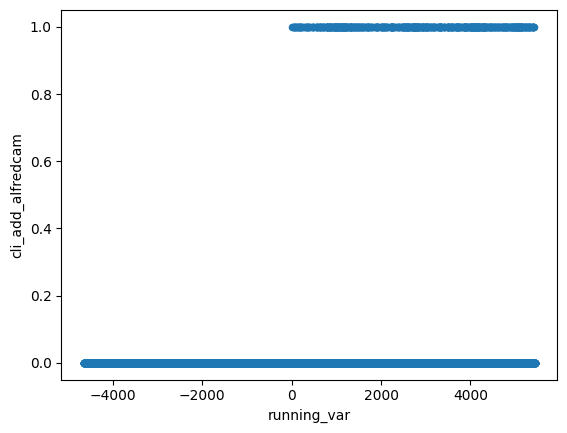

In [323]:
working_sample.plot.scatter(x="running_var",y="cli_add_alfredcam")


In [324]:
working_sample

,UId,usage_purpose,location,lang,country,FirstPlatform,FirstVersion,FirstPlatformViewer,FirstVersionViewer,reg_time,TimeFirstLive,TimeFirstLive_s,TimeFirstSubscribe,click,Platform,first_show_time,second_show_time,SessionId,second_show_sid,click_time,two_show_gap,time_stay_on_page,f0_,slc_30m_rev,last_online,mobile_click,alfredcam_click,web_click,set_later_click,slc_30m_scv,clc_30m_clcs,time_account_first_multi,mat_compl,mobile_click_1d,alfredcam_click_1d,web_click_1d,set_later_click_1d,clc_1d_clcs,pla_ANDROID,pla_IOS,cty_TW,cty_US,lan_ar,lan_de,lan_el,lan_en,lan_en-US,lan_en_US,lan_es,lan_fa,lan_fr,lan_gu,lan_ha,lan_he,lan_hi,lan_id,lan_in,lan_it,lan_iw,lan_ja,lan_kk,lan_ko,lan_ms,lan_my,lan_nl,lan_pt,lan_ru,lan_sq,lan_th,lan_tr,lan_uk,lan_uz,lan_vi,lan_zh,uap_B&K,uap_Home,uap_Mix B&K,uap_Mix HB&K,uap_Mix HP,uap_Mix Home,uap_Mix Other,uap_Mix PB&K,uap_Mix Pet,uap_Other,uap_Pet,uap_Unknown,clo_baby_room,clo_back_door,clo_bedroom,clo_driveway,clo_front_door,clo_garage,clo_kitchen,clo_living_room,clo_office,clo_store,clo_street,clo_yard,ver_2022_12_1,ver_2022_13_0,mul,mul2,running_var,cli_add_alfredcam,cli_add_mobile_device,cli_add_web_camera,cli_camera_list,cli_explore,cli_mobile_device,cli_more,cli_no_camera_yet_add_camera,cli_premium,cli_set_later,cli_switch_role,cli_web_camera
0,0003942a,Mix HP,[],en,US,ANDROID,2022.12.1,ANDROID,2022.12.1,2022-08-21 14:04:45,NaT,NaT,NaT,add_mobile_device,ANDROID,2022-08-21 14:05:47.365001,2022-08-23 17:30:28.810002,1661090630,1661275819,2022-08-21 14:06:13.797002,0-0 2 3:24:41.445001,0-0 0 0:0:26.432001,NaN,3,NaT,1,0,0,0,15,2,NaT,NaT,1,0,0,0,2,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,False,0,-3794.0,0,1,0,0,0,0,0,0,0,0,0,0
1,000a9225,Home,[],en,US,ANDROID,2022.12.1,ANDROID,2022.12.1,2022-08-24 00:04:06,2022-08-24 14:01:17.408,2022-08-24 14:01:07.464013,NaT,set_later,ANDROID,2022-08-24 00:04:20.883001,2022-08-24 00:04:33.486006,1661299168,1661299168,2022-08-24 00:04:30.012002,0-0 0 0:0:12.603005,0-0 0 0:0:9.129001,true,2,2022-08-27 03:14:27.731001,0,0,0,1,4,2,NaT,2022-08-24 14:00:43.300002,0,0,0,1,21,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,True,0,-316.0,0,0,0,0,0,0,0,0,0,1,0,0
2,0019dc9c,Home,[],en,US,ANDROID,2022.12.1,ANDROID,2022.12.1,2022-08-22 21:35:48,2022-08-22 21:45:52.970,2022-08-22 21:45:43.176046,NaT,add_mobile_device,ANDROID,2022-08-22 21:36:04.447001,2022-08-22 21:42:59.376003,1661204134,1661204503,2022-08-22 21:36:08.640001,0-0 0 0:6:54.929002,0-0 0 0:0:4.193,NaN,6,2022-08-29 20:39:24.063000,4,0,0,2,85,28,NaT,2022-08-22 21:45:35.050035,4,0,0,2,69,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,False,0,-1904.0,0,1,0,0,0,0,0,0,0,0,0,0
3,0019e3c7,Unknown,[],en,US,ANDROID,2022.12.1,NaN,NaN,2022-08-21 10:25:59,NaT,NaT,NaT,set_later,ANDROID,2022-08-21 10:26:30.525003,NaT,1661077097,NaN,2022-08-21 10:26:31.911011,NaN,0-0 0 0:0:1.386008,true,1,NaT,0,0,0,1,28,12,2022-08-21 10:25:59,NaT,0,0,0,1,12,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,True,1,-4013.0,0,0,0,0,0,0,0,0,0,1,0,0
4,001cc0df,B&K,[],en,US,ANDROID,2022.12.1,ANDROID,2022.12.1,2022-08-23 22:26:51,NaT,NaT,NaT,add_mobile_device,ANDROID,2022-08-23 22:27:03.898001,2022-08-23 22:27:43.706007,1661293588,1661293588,2022-08-23 22:27:07.121002,0-0 0 0:0:39.808006,0-0 0 0:0:3.223001,NaN,2,NaT,1,0,0,0,5,1,NaT,NaT,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,False,0,-413.0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [325]:
import statsmodels.api as sm
rdd_df = working_sample[(working_sample['running_var'] <= 1440) & (working_sample['running_var'] >= -1440)].assign(threshold=(working_sample["running_var"] > 0).astype(int))
rdd_df['interact'] = rdd_df['running_var'] * rdd_df['threshold']
rdd_df['mul'] = rdd_df['mul'].astype(int)
rdd_df['mul2'] = rdd_df['mul2'].astype(int)

X_list =['running_var','threshold','interact','mul2', 'cty_TW', 'pla_ANDROID', 'pla_IOS', 'uap_B&K',	'uap_Home',	'uap_Mix B&K',	'uap_Mix HB&K',
         'uap_Mix HP',	'uap_Mix Home',	'uap_Mix Other',	'uap_Mix PB&K',	'uap_Mix Pet',	'uap_Other',	'uap_Pet', 'clo_baby_room',	'clo_back_door',
         'clo_bedroom',	'clo_driveway',	'clo_front_door',	'clo_garage',	'clo_kitchen',	'clo_living_room',	'clo_office',	'clo_store',	'clo_street',
         'clo_yard']

X = rdd_df[X_list]
Y = rdd_df[['cli_add_alfredcam']].astype(int)
X = sm.add_constant(X)
model1 = sm.OLS(Y, X).fit(cov_type='HC3')
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      cli_add_alfredcam   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     6.000
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           1.16e-22
Time:                        08:11:48   Log-Likelihood:                 736.66
No. Observations:                3706   AIC:                            -1413.
Df Residuals:                    3676   BIC:                            -1227.
Df Model:                          29                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0052      0.004     -1.321      0.187      -0.013       0.003
running_var      1.464e-06   1.57e-06      0.932      0.351   -1.61e-06    4.54e-06
threshold           0.0625      0.012      5.267      0.000       0.039       0.086
interact         2.714e-05   1.41e-05      1.921      0.055   -5.48e-07    5.48e-05
mul2               -0.0216      0.007     -3.309      0.001      -0.034      -0.009
cty_TW             -0.0016      0.013     -0.130      0.896      -0.026       0.023
pla_ANDROID         0.0123      0.003      3.813      0.000       0.006       0.019
pla_IOS            -0.0175      0.004     -4.126      0.000      -0.026      -0.009
uap_B&K             0.0193      0.014      1.392      0.164      -0.008       0.046
uap_Home            0.0195      0.008      2.434      0.015       0.004       0.035
uap_Mix B&K        -0.0214      0.010     -2.062      0.039      -0.042      -0.001
uap_Mix HB&K        0.0012      0.018      0.066      0.947      -0.034       0.036
uap_Mix HP         -0.0099      0.021     -0.476      0.634      -0.051       0.031
uap_Mix Home        0.0067      0.012      0.572      0.567      -0.016       0.030
uap_Mix Other      -0.0160      0.028     -0.565      0.572      -0.072       0.040
uap_Mix PB&K       -0.0161      0.019     -0.846      0.398      -0.054       0.021
uap_Mix Pet        -0.0341      0.010     -3.263      0.001      -0.055      -0.014
uap_Other           0.0164      0.015      1.096      0.273      -0.013       0.046
uap_Pet            -0.0066      0.013     -0.500      0.617      -0.033       0.019
clo_baby_room      -0.0502      0.012     -4.265      0.000      -0.073      -0.027
clo_back_door      -0.0197      0.016     -1.240      0.215      -0.051       0.011
clo_bedroom        -0.0016      0.017     -0.096      0.923      -0.035       0.032
clo_driveway       -0.0496      0.012     -3.969      0.000      -0.074      -0.025
clo_front_door     -0.0259      0.010     -2.685      0.007      -0.045      -0.007
clo_garage         -0.0056      0.035     -0.163      0.871      -0.074       0.062
clo_kitchen        -0.0099      0.013     -0.755      0.450      -0.036       0.016
clo_living_room    -0.0260      0.009     -2.884      0.004      -0.044      -0.008
clo_office          0.0830      0.074      1.127      0.260      -0.061       0.227
clo_store          -0.0501      0.033     -1.499      0.134      -0.116       0.015
clo_street         -0.0299      0.040     -0.744      0.457      -0.109       0.049
clo_yard           -0.0131      0.027     -0.477      0.633      -0.067       0.041
==============================================================================
Omnibus:                     3024.268   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            

Text(40.63930261381172, 0.5, 'First Click - AlfredCam')

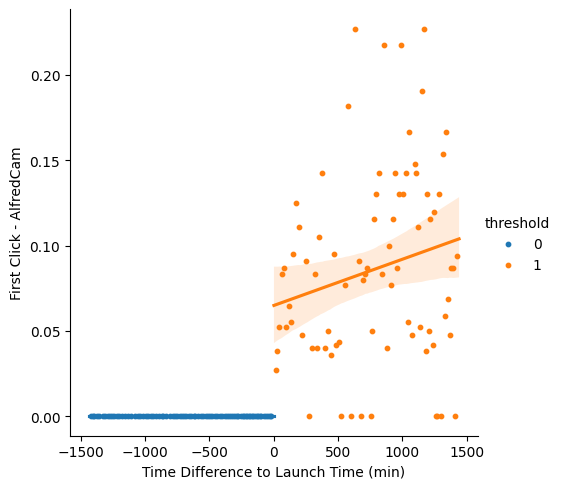

In [326]:
sns.lmplot(data=rdd_df, x="running_var", y="cli_add_alfredcam", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("First Click - AlfredCam")

<ipython-input-327-79c1ea83cfcb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_a1['alfredcam_click'] = rdd_df_a1['alfredcam_click'].astype(int)


Text(39.30079566936729, 0.5, 'Clicks on AlfredCam Within 30m')

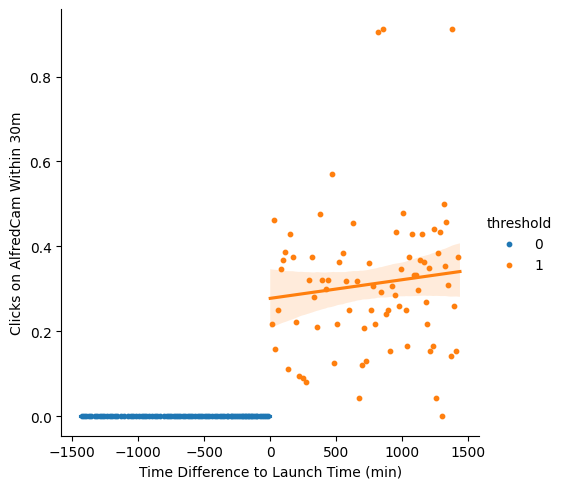

In [327]:
rdd_df_a1 = rdd_df[~(rdd_df['alfredcam_click'].isnull())]
rdd_df_a1['alfredcam_click'] = rdd_df_a1['alfredcam_click'].astype(int)
sns.lmplot(data=rdd_df_a1, x="running_var", y="alfredcam_click", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("Clicks on AlfredCam Within 30m")

<ipython-input-328-7fa28307227e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_a2['alfredcam_click_1d'] = rdd_df_a1['alfredcam_click_1d'].astype(int)


Text(39.30079566936729, 0.5, 'Clicks on AlfredCam Within 1d')

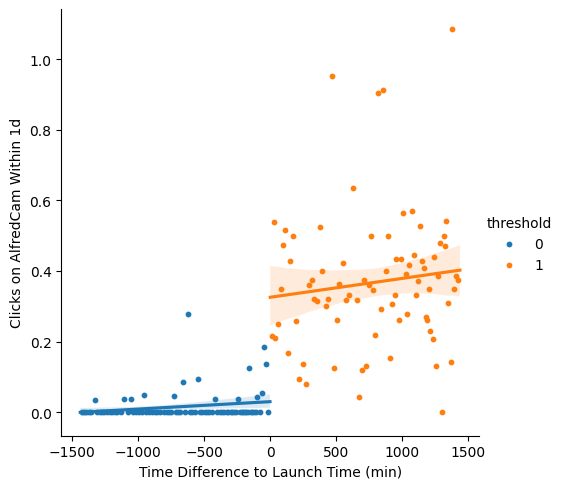

In [328]:
rdd_df_a2 = rdd_df[~(rdd_df['alfredcam_click_1d'].isnull())]
rdd_df_a2['alfredcam_click_1d'] = rdd_df_a1['alfredcam_click_1d'].astype(int)
sns.lmplot(data=rdd_df_a2, x="running_var", y="alfredcam_click_1d", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("Clicks on AlfredCam Within 1d")

# Smoothness Test

Text(40.47716589506172, 0.5, 'register country - US')

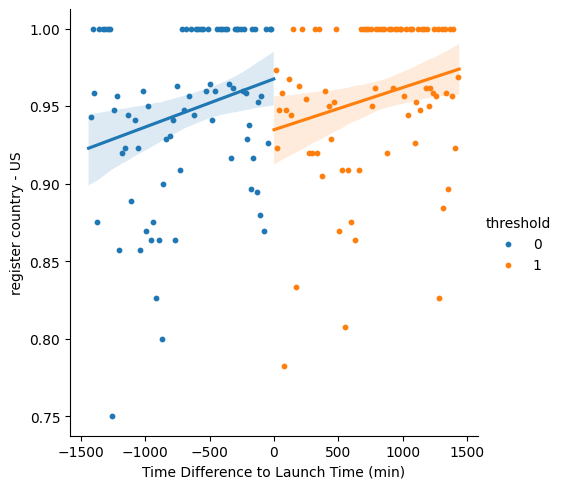

In [329]:
sns.lmplot(data=rdd_df, x="running_var", y="cty_US", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("register country - US")

Text(39.138658950617284, 0.5, 'usage type - Home')

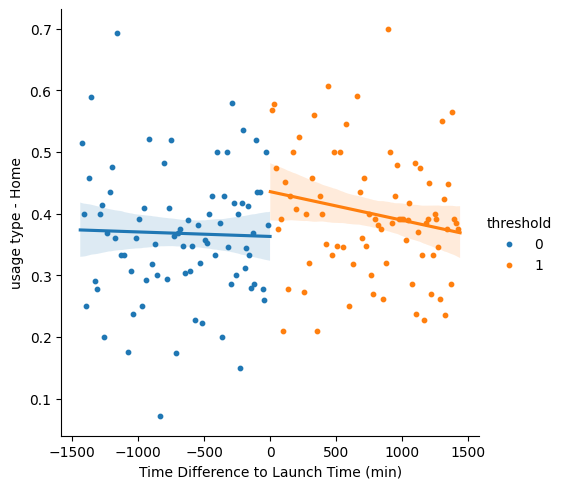

In [330]:
sns.lmplot(data=rdd_df, x="running_var", y="uap_Home", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("usage type - Home")

Text(40.47716589506172, 0.5, 'usage type - B&K')

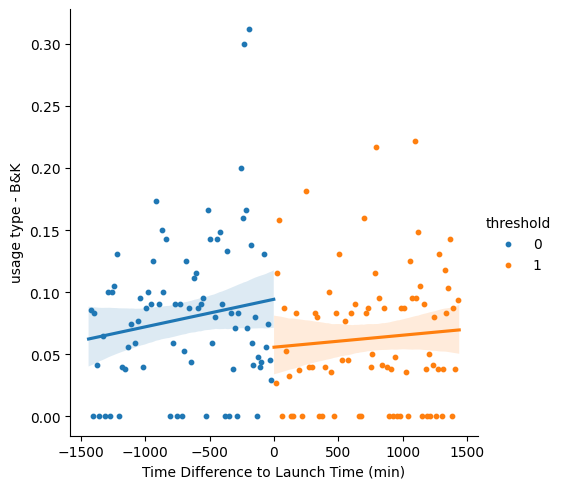

In [331]:
sns.lmplot(data=rdd_df, x="running_var", y="uap_B&K", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("usage type - B&K")

Text(40.47716589506172, 0.5, 'usage type - Pet')

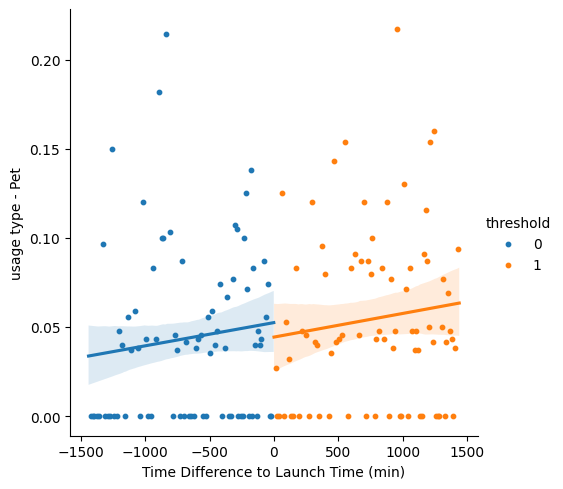

In [332]:
sns.lmplot(data=rdd_df, x="running_var", y="uap_Pet", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("usage type - Pet")

Text(39.30079566936729, 0.5, 'usage type - Unknown')

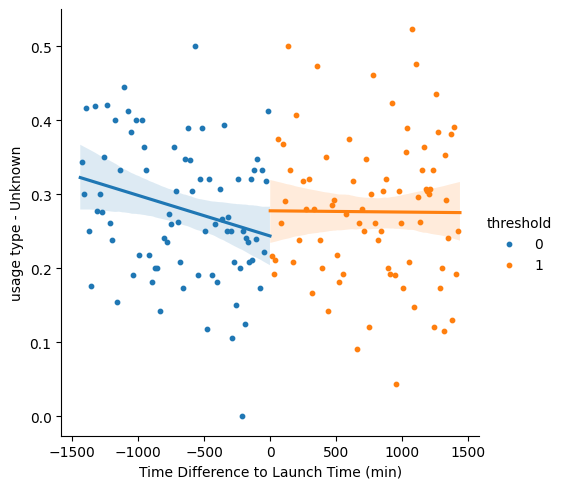

In [333]:
sns.lmplot(data=rdd_df, x="running_var", y="uap_Unknown", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("usage type - Unknown")

Text(40.63930261381172, 0.5, 'usage type - Other')

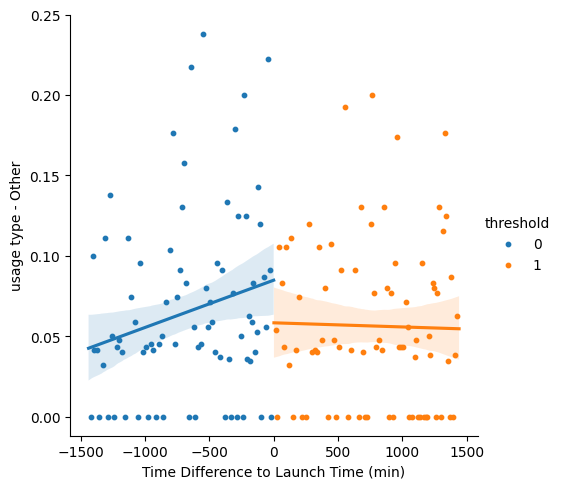

In [334]:
sns.lmplot(data=rdd_df, x="running_var", y="uap_Other", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("usage type - Other")

Text(40.65842414158949, 0.5, 'Camera location - front door')

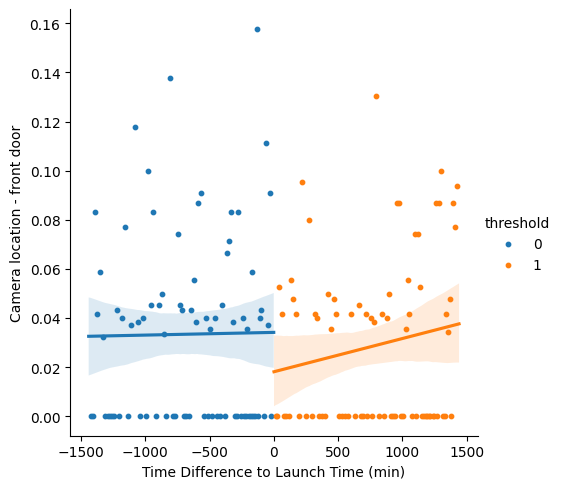

In [335]:
sns.lmplot(data=rdd_df, x="running_var", y="clo_front_door", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("Camera location - front door")

Text(40.63930261381172, 0.5, 'Camera location - Living Room')

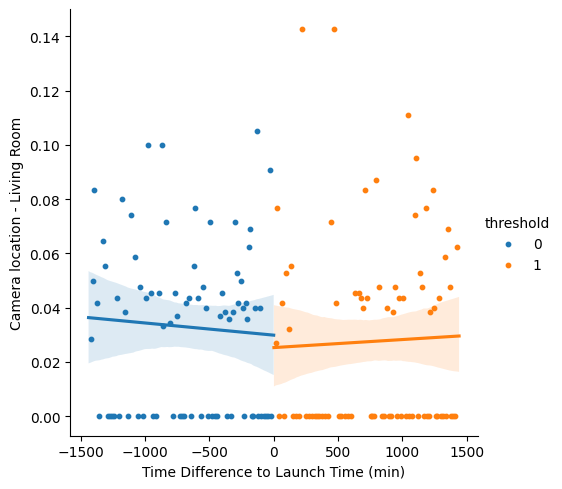

In [336]:
sns.lmplot(data=rdd_df, x="running_var", y="clo_living_room", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("Camera location - Living Room")

# Density Test

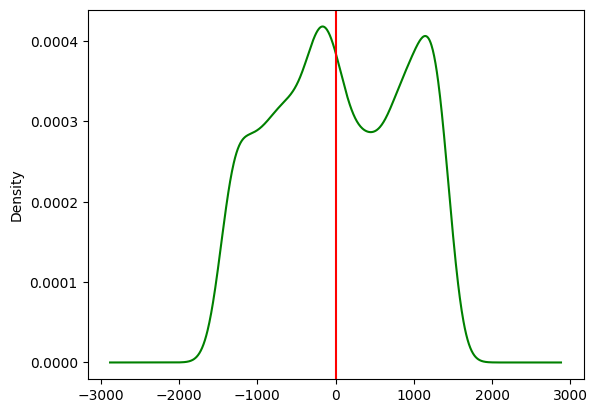

In [337]:
rdd_df.running_var.plot.density(color='green').axvline(x=0, color='red', linestyle='-', label='x=0')

# Main Analysis - new layout to click choice

In [338]:
# old plotting comments
"""
Y_pred = model1.predict(X)

# Calculate confidence intervals for predicted values
pred_results = model1.get_prediction(X)
pred_conf_int = pred_results.conf_int()

bins = range(-1440, 1440, 20)
rdd_df['Bin'] = pd.cut(rdd_df['running_var'], bins=bins, labels=False)
average_by_group_x = rdd_df.groupby('Bin')['running_var'].mean()
average_by_group_y = rdd_df.groupby('Bin')['cli_add_alfredcam'].mean()
plt.scatter(average_by_group_x, average_by_group_y, color="C0", label='Conditional Mean', s=5)

# Plot the regression line
plt.scatter(rdd_df['running_var'], Y_pred, color='C1', label='Regression Line', s=2)

Y_inv = pd.DataFrame(pred_conf_int, columns = ['low', 'high'])
plt.scatter(rdd_df['running_var'], Y_inv['low'], color='gray', label='95% Confidence Interval', s=2)
plt.scatter(rdd_df['running_var'], Y_inv['high'], color='gray', s=2)

# Label axes and add a legend
plt.xlabel('Running Variables')
plt.ylabel('first click Add AlfredCam')
plt.legend()

# Show the plot
plt.show()
"""

'\nY_pred = model1.predict(X)\n\n# Calculate confidence intervals for predicted values\npred_results = model1.get_prediction(X)\npred_conf_int = pred_results.conf_int()\n\nbins = range(-1440, 1440, 20)\nrdd_df[\'Bin\'] = pd.cut(rdd_df[\'running_var\'], bins=bins, labels=False)\naverage_by_group_x = rdd_df.groupby(\'Bin\')[\'running_var\'].mean()\naverage_by_group_y = rdd_df.groupby(\'Bin\')[\'cli_add_alfredcam\'].mean()\nplt.scatter(average_by_group_x, average_by_group_y, color="C0", label=\'Conditional Mean\', s=5)\n\n# Plot the regression line\nplt.scatter(rdd_df[\'running_var\'], Y_pred, color=\'C1\', label=\'Regression Line\', s=2)\n\nY_inv = pd.DataFrame(pred_conf_int, columns = [\'low\', \'high\'])\nplt.scatter(rdd_df[\'running_var\'], Y_inv[\'low\'], color=\'gray\', label=\'95% Confidence Interval\', s=2)\nplt.scatter(rdd_df[\'running_var\'], Y_inv[\'high\'], color=\'gray\', s=2)\n\n# Label axes and add a legend\nplt.xlabel(\'Running Variables\')\nplt.ylabel(\'first click Add Al

In [339]:
Y = rdd_df[['cli_web_camera']].astype(int)
model2 = sm.OLS(Y, X).fit(cov_type='HC3')
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         cli_web_camera   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.03329
Date:                Wed, 30 Aug 2023   Prob (F-statistic):               1.00
Time:                        08:12:02   Log-Likelihood:                 9979.7
No. Observations:                3706   AIC:                        -1.990e+04
Df Residuals:                    3676   BIC:                        -1.971e+04
Df Model:                          29                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0006      0.001     -0.998      0.319      -0.002       0.001
running_var     -1.285e-07   1.45e-07     -0.889      0.374   -4.12e-07    1.55e-07
threshold        9.779e-05      0.000      0.771      0.440      -0.000       0.000
interact          8.45e-07   8.51e-07      0.994      0.320   -8.22e-07    2.51e-06
mul2                0.0011      0.001      0.999      0.318      -0.001       0.003
cty_TW             -0.0002      0.000     -0.918      0.359      -0.001       0.000
pla_ANDROID        -0.0001      0.000     -0.976      0.329      -0.000       0.000
pla_IOS            -0.0005      0.000     -0.997      0.319      -0.001       0.000
uap_B&K             0.0003      0.000      0.989      0.323      -0.000       0.001
uap_Home            0.0002      0.000      0.987      0.324      -0.000       0.001
uap_Mix B&K         0.0002      0.000      0.806      0.420      -0.000       0.001
uap_Mix HB&K        0.0003      0.000      0.967      0.333      -0.000       0.001
uap_Mix HP          0.0004      0.000      0.979      0.328      -0.000       0.001
uap_Mix Home        0.0002      0.000      0.982      0.326      -0.000       0.001
uap_Mix Other       0.0005      0.001      0.632      0.527      -0.001       0.002
uap_Mix PB&K        0.0005      0.000      0.945      0.345      -0.000       0.001
uap_Mix Pet         0.0003      0.000      0.921      0.357      -0.000       0.001
uap_Other           0.0047      0.005      0.998      0.318      -0.005       0.014
uap_Pet             0.0002      0.000      0.962      0.336      -0.000       0.001
clo_baby_room      -0.0002      0.000     -0.745      0.456      -0.001       0.000
clo_back_door       0.0002      0.000      0.677      0.499      -0.000       0.001
clo_bedroom        -0.0002      0.000     -0.904      0.366      -0.001       0.000
clo_driveway        0.0003      0.000      0.907      0.364      -0.000       0.001
clo_front_door     -0.0002      0.000     -0.855      0.392      -0.001       0.000
clo_garage         -0.0007      0.001     -0.900      0.368      -0.002       0.001
clo_kitchen         0.0002      0.000      0.689      0.491      -0.000       0.001
clo_living_room    -0.0001      0.000     -0.590      0.555      -0.000       0.000
clo_office       6.184e-05      0.000      0.310      0.757      -0.000       0.000
clo_store          -0.0009      0.002     -0.608      0.543      -0.004       0.002
clo_street         -0.0008      0.001     -0.920      0.357      -0.002       0.001
clo_yard           -0.0006      0.001     -0.920      0.358      -0.002       0.001
==============================================================================
Omnibus:                    12545.291   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       20703

Text(40.63930261381172, 0.5, 'First Click - Web Camera')

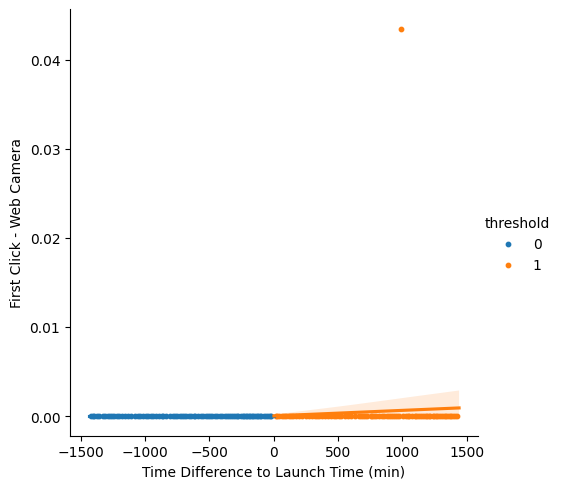

In [340]:
sns.lmplot(data=rdd_df, x="running_var", y="cli_web_camera", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("First Click - Web Camera")

In [341]:
Y = rdd_df[['cli_set_later']].astype(int)

model3 = sm.OLS(Y, X).fit(cov_type='HC3')
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          cli_set_later   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     33.30
Date:                Wed, 30 Aug 2023   Prob (F-statistic):          3.39e-167
Time:                        08:12:03   Log-Likelihood:                -1780.9
No. Observations:                3706   AIC:                             3622.
Df Residuals:                    3676   BIC:                             3808.
Df Model:                          29                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2137      0.015     14.025      0.000       0.184       0.244
running_var       4.65e-06   2.16e-05      0.215      0.830   -3.78e-05    4.71e-05
threshold           0.0307      0.026      1.165      0.244      -0.021       0.082
interact        -4.538e-05   3.08e-05     -1.473      0.141      -0.000     1.5e-05
mul2                0.0368      0.015      2.444      0.015       0.007       0.066
cty_TW             -0.0138      0.029     -0.478      0.632      -0.070       0.043
pla_ANDROID         0.1179      0.010     11.757      0.000       0.098       0.138
pla_IOS             0.0958      0.012      8.250      0.000       0.073       0.119
uap_B&K            -0.2238      0.024     -9.264      0.000      -0.271      -0.176
uap_Home           -0.1742      0.018     -9.846      0.000      -0.209      -0.140
uap_Mix B&K        -0.1174      0.104     -1.126      0.260      -0.322       0.087
uap_Mix HB&K       -0.1733      0.043     -4.033      0.000      -0.258      -0.089
uap_Mix HP         -0.0959      0.062     -1.546      0.122      -0.217       0.026
uap_Mix Home       -0.1549      0.025     -6.315      0.000      -0.203      -0.107
uap_Mix Other      -0.0056      0.397     -0.014      0.989      -0.783       0.772
uap_Mix PB&K        0.0454      0.196      0.232      0.817      -0.339       0.429
uap_Mix Pet        -0.2337      0.056     -4.183      0.000      -0.343      -0.124
uap_Other          -0.1577      0.029     -5.402      0.000      -0.215      -0.101
uap_Pet            -0.2083      0.028     -7.341      0.000      -0.264      -0.153
clo_baby_room       0.0076      0.075      0.102      0.919      -0.139       0.154
clo_back_door       0.0385      0.090      0.431      0.667      -0.137       0.214
clo_bedroom        -0.0475      0.028     -1.713      0.087      -0.102       0.007
clo_driveway       -0.0995      0.066     -1.513      0.130      -0.228       0.029
clo_front_door     -0.0219      0.036     -0.605      0.545      -0.093       0.049
clo_garage         -0.0158      0.066     -0.238      0.812      -0.146       0.114
clo_kitchen        -0.0299      0.073     -0.412      0.680      -0.172       0.112
clo_living_room    -0.0350      0.034     -1.016      0.309      -0.102       0.032
clo_office          0.1671      0.116      1.439      0.150      -0.060       0.395
clo_store          -0.1905      0.044     -4.344      0.000      -0.276      -0.105
clo_street         -0.1206      0.061     -1.976      0.048      -0.240      -0.001
clo_yard           -0.0399      0.059     -0.682      0.495      -0.155       0.075
==============================================================================
Omnibus:                      695.795   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            

In [342]:
# old plotting comments
"""
Y_pred = model3.predict(X)

# Calculate confidence intervals for predicted values
pred_results = model3.get_prediction(X)
pred_conf_int = pred_results.conf_int()

bins = range(-1440, 1440, 20)
rdd_df['Bin'] = pd.cut(rdd_df['running_var'], bins=bins, labels=False)
average_by_group_x = rdd_df.groupby('Bin')['running_var'].mean()
average_by_group_y = rdd_df.groupby('Bin')['cli_set_later'].mean()
plt.scatter(average_by_group_x, average_by_group_y, color="C0", label='Conditional Mean', s=5)

# Plot the regression line
plt.scatter(rdd_df['running_var'], Y_pred, color='C1', label='Regression Line', s=2)

Y_inv = pd.DataFrame(pred_conf_int, columns = ['low', 'high'])
plt.scatter(rdd_df['running_var'], Y_inv['low'], color='gray', label='95% Confidence Interval', s=2)
plt.scatter(rdd_df['running_var'], Y_inv['high'], color='gray', s=2)

# Label axes and add a legend
plt.xlabel('Running Variables')
plt.ylabel('first click Set Later')
plt.legend()

# Show the plot
plt.show()
"""

'\nY_pred = model3.predict(X)\n\n# Calculate confidence intervals for predicted values\npred_results = model3.get_prediction(X)\npred_conf_int = pred_results.conf_int()\n\nbins = range(-1440, 1440, 20)\nrdd_df[\'Bin\'] = pd.cut(rdd_df[\'running_var\'], bins=bins, labels=False)\naverage_by_group_x = rdd_df.groupby(\'Bin\')[\'running_var\'].mean()\naverage_by_group_y = rdd_df.groupby(\'Bin\')[\'cli_set_later\'].mean()\nplt.scatter(average_by_group_x, average_by_group_y, color="C0", label=\'Conditional Mean\', s=5)\n\n# Plot the regression line\nplt.scatter(rdd_df[\'running_var\'], Y_pred, color=\'C1\', label=\'Regression Line\', s=2)\n\nY_inv = pd.DataFrame(pred_conf_int, columns = [\'low\', \'high\'])\nplt.scatter(rdd_df[\'running_var\'], Y_inv[\'low\'], color=\'gray\', label=\'95% Confidence Interval\', s=2)\nplt.scatter(rdd_df[\'running_var\'], Y_inv[\'high\'], color=\'gray\', s=2)\n\n# Label axes and add a legend\nplt.xlabel(\'Running Variables\')\nplt.ylabel(\'first click Set Later\

Text(39.30079566936729, 0.5, 'First Click - Set Later')

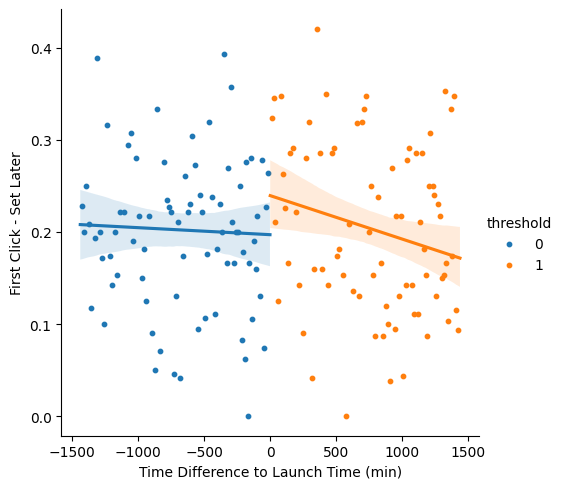

In [343]:
sns.lmplot(data=rdd_df, x="running_var", y="cli_set_later", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("First Click - Set Later")

<ipython-input-344-7ffcf62037d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_a1['set_later_click'] = rdd_df_a1['set_later_click'].astype(int)


Text(39.30079566936729, 0.5, 'Clicks on set later Within 30m')

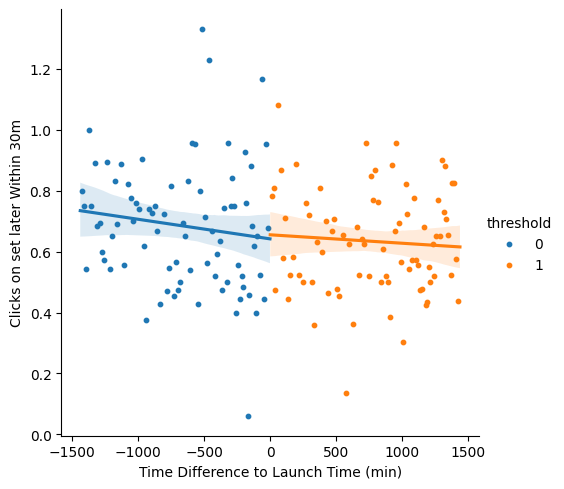

In [344]:
rdd_df_a1 = rdd_df[~(rdd_df['set_later_click'].isnull())]
rdd_df_a1['set_later_click'] = rdd_df_a1['set_later_click'].astype(int)
sns.lmplot(data=rdd_df_a1, x="running_var", y="set_later_click", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("Clicks on set later Within 30m")

<ipython-input-345-a24db1f7195d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_a2['set_later_click_1d'] = rdd_df_a1['set_later_click_1d'].astype(int)


Text(40.63930261381172, 0.5, 'Clicks on set later Within 1d')

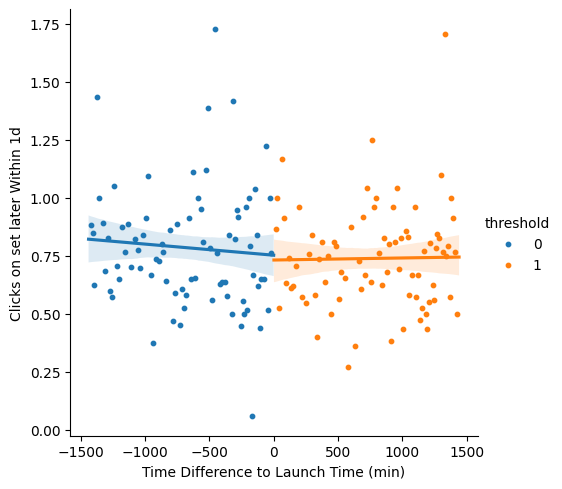

In [345]:
rdd_df_a2 = rdd_df[~(rdd_df['set_later_click_1d'].isnull())]
rdd_df_a2['set_later_click_1d'] = rdd_df_a1['set_later_click_1d'].astype(int)
sns.lmplot(data=rdd_df_a2, x="running_var", y="set_later_click_1d", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("Clicks on set later Within 1d")

In [346]:
Y = rdd_df[['cli_add_mobile_device']].astype(int)
model4 = sm.OLS(Y, X).fit(cov_type='HC3')
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     cli_add_mobile_device   R-squared:                       0.046
Model:                               OLS   Adj. R-squared:                  0.038
Method:                    Least Squares   F-statistic:                     344.4
Date:                   Wed, 30 Aug 2023   Prob (F-statistic):               0.00
Time:                           08:12:06   Log-Likelihood:                -2271.0
No. Observations:                   3706   AIC:                             4602.
Df Residuals:                       3676   BIC:                             4789.
Df Model:                             29                                         
Covariance Type:                     HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4225      0.017     25.588      0.000       0.390       0.455
running_var     -1.992e-06   2.39e-05     -0.083      0.933   -4.88e-05    4.48e-05
threshold          -0.0759      0.029     -2.586      0.010      -0.133      -0.018
interact         1.763e-05   3.46e-05      0.510      0.610   -5.01e-05    8.54e-05
mul2               -0.0126      0.017     -0.750      0.453      -0.046       0.020
cty_TW              0.0520      0.032      1.641      0.101      -0.010       0.114
pla_ANDROID         0.1781      0.011     16.244      0.000       0.157       0.200
pla_IOS             0.2444      0.013     18.979      0.000       0.219       0.270
uap_B&K             0.1883      0.030      6.380      0.000       0.130       0.246
uap_Home            0.1492      0.019      7.682      0.000       0.111       0.187
uap_Mix B&K         0.0786      0.122      0.644      0.519      -0.161       0.318
uap_Mix HB&K        0.1467      0.050      2.956      0.003       0.049       0.244
uap_Mix HP          0.0490      0.070      0.695      0.487      -0.089       0.187
uap_Mix Home        0.1376      0.028      4.969      0.000       0.083       0.192
uap_Mix Other       0.0709      0.410      0.173      0.863      -0.733       0.875
uap_Mix PB&K        0.0248      0.197      0.126      0.900      -0.361       0.411
uap_Mix Pet         0.3158      0.057      5.533      0.000       0.204       0.428
uap_Other           0.1164      0.034      3.437      0.001       0.050       0.183
uap_Pet             0.2268      0.032      7.046      0.000       0.164       0.290
clo_baby_room       0.0554      0.078      0.712      0.477      -0.097       0.208
clo_back_door      -0.0143      0.096     -0.149      0.882      -0.203       0.175
clo_bedroom         0.0529      0.034      1.552      0.121      -0.014       0.120
clo_driveway        0.1526      0.078      1.954      0.051      -0.000       0.306
clo_front_door      0.0970      0.038      2.578      0.010       0.023       0.171
clo_garage          0.0057      0.079      0.071      0.943      -0.150       0.161
clo_kitchen         0.0560      0.082      0.679      0.497      -0.106       0.217
clo_living_room     0.0417      0.040      1.051      0.293      -0.036       0.119
clo_office         -0.3071      0.129     -2.383      0.017      -0.560      -0.055
clo_store           0.0921      0.229      0.402      0.687      -0.357       0.541
clo_street          0.1685      0.076      2.230      0.026       0.020       0.317
clo_yard            0.0713      0.068      1.053      0.293      -0.061       0.204
==============================================================================
Omnibus:                     1975.881   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.00

Text(39.30079566936729, 0.5, 'First Click - Add Mobile Device')

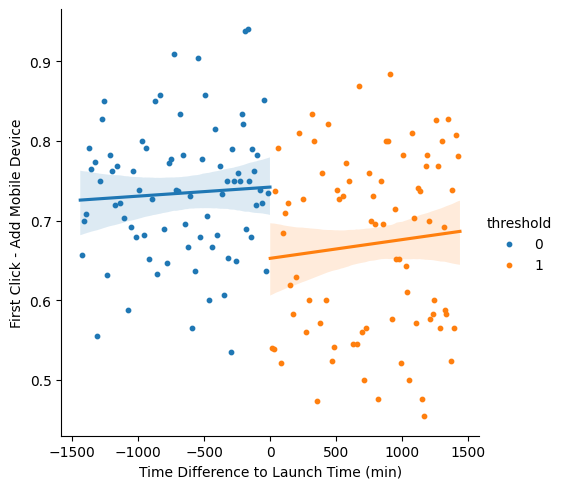

In [347]:
sns.lmplot(data=rdd_df, x="running_var", y="cli_add_mobile_device", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("First Click - Add Mobile Device")

<ipython-input-348-22a0df008460>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_a1['mobile_click'] = rdd_df_a1['mobile_click'].astype(int)


Text(40.63930261381172, 0.5, 'Clicks on Add Mobile Device Within 30m')

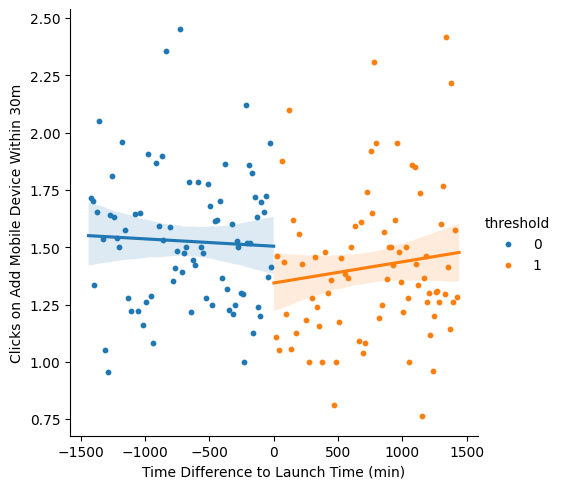

In [348]:
rdd_df_a1 = rdd_df[~(rdd_df['mobile_click'].isnull())]
rdd_df_a1['mobile_click'] = rdd_df_a1['mobile_click'].astype(int)
sns.lmplot(data=rdd_df_a1, x="running_var", y="mobile_click", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("Clicks on Add Mobile Device Within 30m")

<ipython-input-349-ce69fe9a55cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_a1['mobile_click_1d'] = rdd_df_a1['mobile_click_1d'].astype(int)


Text(39.30079566936729, 0.5, 'Clicks on Add Mobile Device Within 1d')

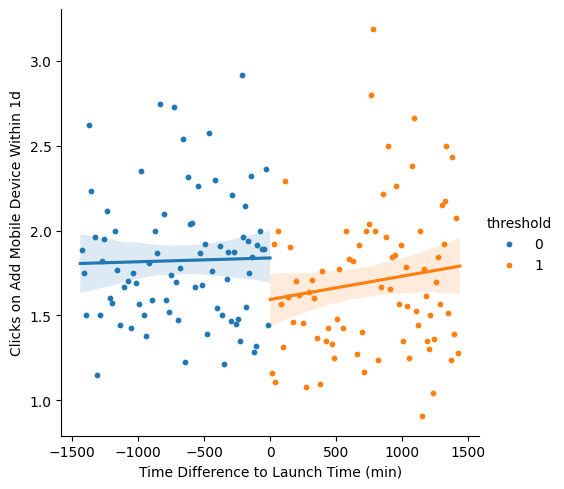

In [349]:
rdd_df_a1 = rdd_df[~(rdd_df['mobile_click_1d'].isnull())]
rdd_df_a1['mobile_click_1d'] = rdd_df_a1['mobile_click_1d'].astype(int)
sns.lmplot(data=rdd_df_a1, x="running_var", y="mobile_click_1d", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("Clicks on Add Mobile Device Within 1d")

In [350]:
rdd_df_a1 = rdd_df[~(rdd_df['mobile_click'].isnull())]
rdd_df_a1['mobile_click'] = rdd_df_a1['mobile_click'].astype(int)
X = rdd_df_a1[['running_var', 'threshold','interact','mul2', 'cty_TW', 'pla_ANDROID', 'pla_IOS', 'uap_B&K',	'uap_Home',	'uap_Mix B&K',	'uap_Mix HB&K',	'uap_Mix HP',	'uap_Mix Home',	'uap_Mix Other',	'uap_Mix PB&K',	'uap_Mix Pet',	'uap_Other',	'uap_Pet']]
X = sm.add_constant(X)
Y = rdd_df_a1['mobile_click']
modelt = sm.OLS(Y, X).fit(cov_type='HC3')
modelt.summary()

<ipython-input-350-84d56bca19cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_a1['mobile_click'] = rdd_df_a1['mobile_click'].astype(int)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           mobile_click   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     236.8
Date:                Wed, 30 Aug 2023   Prob (F-statistic):               0.00
Time:                        08:12:12   Log-Likelihood:                -6585.3
No. Observations:                3704   AIC:                         1.321e+04
Df Residuals:                    3686   BIC:                         1.332e+04
Df Model:                          17                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8651      0.054     16.152      0.000       0.760       0.970
running_var   -4.449e-05   7.71e-05     -0.577      0.564      -0.000       0.000
threshold        -0.1530      0.087     -1.759      0.079      -0.324       0.017
interact          0.0001      0.000      1.272      0.203   -7.53e-05       0.000
mul2              0.0306      0.053      0.573      0.567      -0.074       0.135
cty_TW            0.0891      0.126      0.707      0.479      -0.158       0.336
pla_ANDROID       0.4598      0.034     13.511      0.000       0.393       0.527
pla_IOS           0.4053      0.043      9.533      0.000       0.322       0.489
uap_B&K           0.4627      0.121      3.826      0.000       0.226       0.700
uap_Home          0.2305      0.060      3.856      0.000       0.113       0.348
uap_Mix B&K      -0.1324      0.230     -0.575      0.565      -0.584       0.319
uap_Mix HB&K      0.1811      0.148      1.220      0.222      -0.110       0.472
uap_Mix HP        0.0604      0.163      0.370      0.711      -0.260       0.381
uap_Mix Home      0.0894      0.081      1.103      0.270      -0.069       0.248
uap_Mix Other    -0.3003      0.093     -3.216      0.001      -0.483      -0.117
uap_Mix PB&K      0.0592      0.291      0.203      0.839      -0.511       0.630
uap_Mix Pet       0.4139      0.186      2.220      0.026       0.049       0.779
uap_Other         0.2221      0.123      1.809      0.070      -0.019       0.463
uap_Pet           0.3691      0.121      3.060      0.002       0.133       0.606
==============================================================================
Omnibus:                     2357.573   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37556.681
Skew:                           2.784   Prob(JB):                         0.00
Kurtosis:                      17.572   Cond. No.                     3.63e+17
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 2.78e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Observations:
1. More people click on alfredcam, less people click on Mobile Device
2. There's no increace in people clicking on set later (less likely to be choice fatigue)



In [351]:
rdd_df['click_time_diff'] = (((rdd_df['click_time'] - rdd_df['first_show_time'])).apply(lambda x: x.total_seconds())).to_frame(name = 'click_time_diff')

In [352]:
rdd_df['click_time_diff'].describe(percentiles = [0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.9])

count    3706.000000
mean       32.748491
std       144.199993
min         0.023999
50%         6.629001
90%        32.965501
91%        38.366301
92%        45.300001
93%        52.649948
94%        70.147001
95%        94.636753
96%       125.983401
97%       185.686299
98%       357.262205
99%       646.842053
max      2265.124999
Name: click_time_diff, dtype: float64

In [353]:
X = rdd_df[X_list]
X = sm.add_constant(X)
Y = rdd_df['click_time_diff']
model5 = sm.OLS(Y, X).fit(cov_type='HC3')
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        click_time_diff   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     9.051
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           4.71e-39
Time:                        08:12:12   Log-Likelihood:                -23658.
No. Observations:                3706   AIC:                         4.738e+04
Df Residuals:                    3676   BIC:                         4.756e+04
Df Model:                          29                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.9975      5.242      2.670      0.008       3.724      24.271
running_var        -0.0057      0.008     -0.671      0.502      -0.022       0.011
threshold          11.8972      9.966      1.194      0.233      -7.636      31.430
interact           -0.0050      0.012     -0.423      0.672      -0.028       0.018
mul2              -15.9930      4.924     -3.248      0.001     -25.643      -6.343
cty_TW            -21.6184      3.706     -5.834      0.000     -28.882     -14.355
pla_ANDROID        15.4248      3.006      5.131      0.000       9.533      21.316
pla_IOS            -1.4273      3.598     -0.397      0.692      -8.479       5.624
uap_B&K            11.5395     10.970      1.052      0.293      -9.962      33.041
uap_Home           10.4057      5.701      1.825      0.068      -0.767      21.579
uap_Mix B&K        -0.4383     19.605     -0.022      0.982     -38.862      37.986
uap_Mix HB&K       -0.8884     10.932     -0.081      0.935     -22.315      20.538
uap_Mix HP          0.8485      8.965      0.095      0.925     -16.724      18.421
uap_Mix Home       16.2940     10.162      1.603      0.109      -3.624      36.212
uap_Mix Other     -17.4565     11.944     -1.462      0.144     -40.866       5.953
uap_Mix PB&K      -20.5168      6.369     -3.221      0.001     -33.001      -8.033
uap_Mix Pet        51.3180     45.778      1.121      0.262     -38.405     141.041
uap_Other          10.0736     10.320      0.976      0.329     -10.153      30.300
uap_Pet             9.9593      9.751      1.021      0.307      -9.152      29.071
clo_baby_room     -12.4383     12.786     -0.973      0.331     -37.498      12.621
clo_back_door     -35.2869     11.049     -3.194      0.001     -56.943     -13.630
clo_bedroom        19.2397     17.590      1.094      0.274     -15.237      53.716
clo_driveway      -25.6649      5.432     -4.725      0.000     -36.311     -15.019
clo_front_door     12.6017     15.958      0.790      0.430     -18.675      43.879
clo_garage          1.7702     20.418      0.087      0.931     -38.248      41.789
clo_kitchen        16.7019     42.329      0.395      0.693     -66.261      99.665
clo_living_room     7.4493     13.899      0.536      0.592     -19.792      34.690
clo_office         12.2189     45.554      0.268      0.789     -77.066     101.504
clo_store         -28.1229      9.929     -2.832      0.005     -47.584      -8.662
clo_street         25.6175     29.886      0.857      0.391     -32.958      84.193
clo_yard          -18.8906     10.842     -1.742      0.081     -40.141       2.360
==============================================================================
Omnibus:                     5472.803   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          15

After Removing the outliers (top 2 percentile), the result is rather stable. Adding the button induces a 1.5 ~ 2 second increase in reaction time.

In [354]:
rdd_df_amed = rdd_df[rdd_df['click_time_diff']<=95.280000]
X = rdd_df_amed[X_list]
X = sm.add_constant(X)
Y = rdd_df_amed['click_time_diff']
model5a = sm.OLS(Y, X).fit(cov_type='HC3')
model5a.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        click_time_diff   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     85.55
Date:                Wed, 30 Aug 2023   Prob (F-statistic):               0.00
Time:                        08:12:12   Log-Likelihood:                -13874.
No. Observations:                3521   AIC:                         2.781e+04
Df Residuals:                    3491   BIC:                         2.799e+04
Df Model:                          29                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.0247      0.408     14.761      0.000       5.225       6.825
running_var        -0.0003      0.001     -0.520      0.603      -0.002       0.001
threshold           2.0153      0.787      2.560      0.010       0.472       3.558
interact           -0.0003      0.001     -0.356      0.722      -0.002       0.001
mul2               -3.4740      0.422     -8.235      0.000      -4.301      -2.647
cty_TW             -1.8440      0.751     -2.456      0.014      -3.316      -0.372
pla_ANDROID         4.0431      0.287     14.088      0.000       3.481       4.606
pla_IOS             1.9816      0.335      5.919      0.000       1.325       2.638
uap_B&K            -0.4391      0.850     -0.516      0.606      -2.105       1.227
uap_Home            1.3219      0.490      2.696      0.007       0.361       2.283
uap_Mix B&K        -0.7774      2.308     -0.337      0.736      -5.300       3.746
uap_Mix HB&K        1.3385      1.595      0.839      0.401      -1.788       4.465
uap_Mix HP          2.2151      2.044      1.084      0.278      -1.791       6.221
uap_Mix Home        2.2917      0.850      2.696      0.007       0.626       3.958
uap_Mix Other      -3.8662      3.812     -1.014      0.311     -11.338       3.606
uap_Mix PB&K       -2.5283      1.436     -1.761      0.078      -5.343       0.286
uap_Mix Pet         5.1792      3.125      1.658      0.097      -0.945      11.303
uap_Other           2.7562      1.119      2.463      0.014       0.563       4.949
uap_Pet             0.2549      0.977      0.261      0.794      -1.660       2.170
clo_baby_room      -0.3728      1.706     -0.218      0.827      -3.717       2.972
clo_back_door      -1.0812      2.106     -0.513      0.608      -5.209       3.047
clo_bedroom         1.6487      1.172      1.406      0.160      -0.649       3.947
clo_driveway        0.4802      2.322      0.207      0.836      -4.071       5.031
clo_front_door     -1.1714      1.308     -0.896      0.370      -3.735       1.392
clo_garage         -1.4398      1.737     -0.829      0.407      -4.843       1.964
clo_kitchen        -0.4708      1.712     -0.275      0.783      -3.825       2.884
clo_living_room     2.3152      1.578      1.467      0.142      -0.778       5.409
clo_office          1.5466      3.029      0.511      0.610      -4.391       7.484
clo_store          -0.1977      3.724     -0.053      0.958      -7.496       7.101
clo_street          2.5573      2.959      0.864      0.387      -3.242       8.356
clo_yard            1.1754      2.166      0.543      0.587      -3.069       5.420
==============================================================================
Omnibus:                     2355.824   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            

In [355]:
# old plotting comments
"""
Y_pred = model4.predict(X)

# Calculate confidence intervals for predicted values
pred_results = model4.get_prediction(X)
pred_conf_int = pred_results.conf_int()

bins = range(-1440, 1440, 20)
rdd_df_amed['Bin'] = pd.cut(rdd_df_amed['running_var'], bins=bins, labels=False)
average_by_group_x = rdd_df_amed.groupby('Bin')['running_var'].mean()
average_by_group_y = rdd_df_amed.groupby('Bin')['click_time_diff'].mean()
plt.scatter(average_by_group_x, average_by_group_y, color="C0", label='Conditional Mean', s=5)

# Plot the regression line
plt.scatter(rdd_df_amed['running_var'], Y_pred, color='C1', label='Regression Line', s=2)

Y_inv = pd.DataFrame(pred_conf_int, columns = ['low', 'high'])
plt.scatter(rdd_df_amed['running_var'], Y_inv['low'], color='gray', label='95% Confidence Interval', s=2)
plt.scatter(rdd_df_amed['running_var'], Y_inv['high'], color='gray', s=2)

# Label axes and add a legend
plt.xlabel('Running Variables')
plt.ylabel('first click time difference')
plt.legend()

# Show the plot
plt.show()
"""

'\nY_pred = model4.predict(X)\n\n# Calculate confidence intervals for predicted values\npred_results = model4.get_prediction(X)\npred_conf_int = pred_results.conf_int()\n\nbins = range(-1440, 1440, 20)\nrdd_df_amed[\'Bin\'] = pd.cut(rdd_df_amed[\'running_var\'], bins=bins, labels=False)\naverage_by_group_x = rdd_df_amed.groupby(\'Bin\')[\'running_var\'].mean()\naverage_by_group_y = rdd_df_amed.groupby(\'Bin\')[\'click_time_diff\'].mean()\nplt.scatter(average_by_group_x, average_by_group_y, color="C0", label=\'Conditional Mean\', s=5)\n\n# Plot the regression line\nplt.scatter(rdd_df_amed[\'running_var\'], Y_pred, color=\'C1\', label=\'Regression Line\', s=2)\n\nY_inv = pd.DataFrame(pred_conf_int, columns = [\'low\', \'high\'])\nplt.scatter(rdd_df_amed[\'running_var\'], Y_inv[\'low\'], color=\'gray\', label=\'95% Confidence Interval\', s=2)\nplt.scatter(rdd_df_amed[\'running_var\'], Y_inv[\'high\'], color=\'gray\', s=2)\n\n# Label axes and add a legend\nplt.xlabel(\'Running Variables\')

Text(38.65066372492284, 0.5, 'Time Difference Between Pageview and Click (sec)')

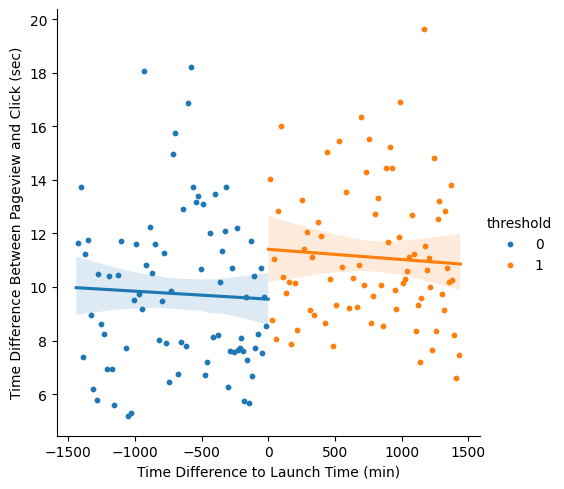

In [356]:
sns.lmplot(data=rdd_df_amed, x="running_var", y="click_time_diff", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("Time Difference Between Pageview and Click (sec)")

Summary:

1. More people click on alfredcam, less people click on Mobile Device
2. There's no increace in people clicking on set later
3. in crease recation time for choosing devices - could be a supportive evidence for Decision Fatigue
4. After Controlling for the state of owning multiple accounts, all the discontinuity preserved, increase reaction time seems more precisely estimated

# Main Analysis - new layout to valid behavior

Here I want to answer three questions:

1. does it affect paring successiful rate? - first enter camera list time
2. Did the new layout affects valid rate?

In [357]:
rdd_df[rdd_df['mat_compl'].isnull()]
rdd_df['match_time_diff'] = (((rdd_df['mat_compl'] - rdd_df['first_show_time'])).apply(lambda x: x.total_seconds())).to_frame(name = 'match_time_diff')

In [358]:
rdd_df['match_success'] = (~rdd_df['mat_compl'].isnull()).astype(int)
rdd_df['live_time_diff'] = (((rdd_df['TimeFirstLive_s'] - rdd_df['first_show_time'])).apply(lambda x: x.total_seconds())).to_frame(name = 'match_time_diff')
rdd_df['ever_live'] = rdd_df['TimeFirstLive'].isnull().astype(int)

rdd_df_amed2 = rdd_df[(rdd_df['click_time_diff']<=60) & ~(rdd_df['match_time_diff'] < 0)]
rdd_df_amed2['freq'] = rdd_df_amed2.groupby('click')['UId'].transform('count') / len(rdd_df_amed2)

<ipython-input-358-aaa3092fda58>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_amed2['freq'] = rdd_df_amed2.groupby('click')['UId'].transform('count') / len(rdd_df_amed2)


Text(39.30079566936729, 0.5, 'Successfully Match Device within 1 Days')

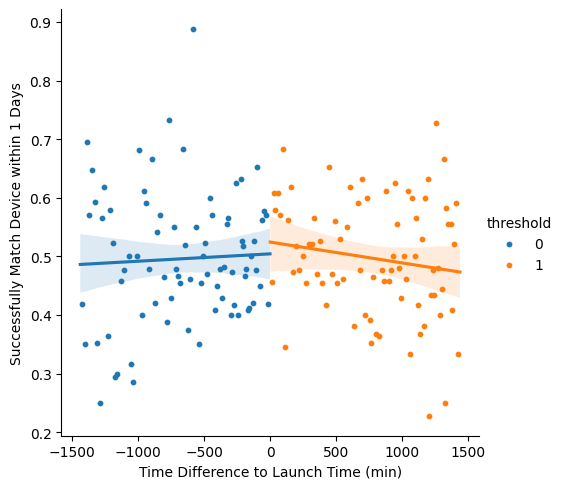

In [359]:
sns.lmplot(data=rdd_df_amed2, x="running_var", y="match_success", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("Successfully Match Device within 1 Days")

Text(39.30079566936729, 0.5, 'User Ever Valid')

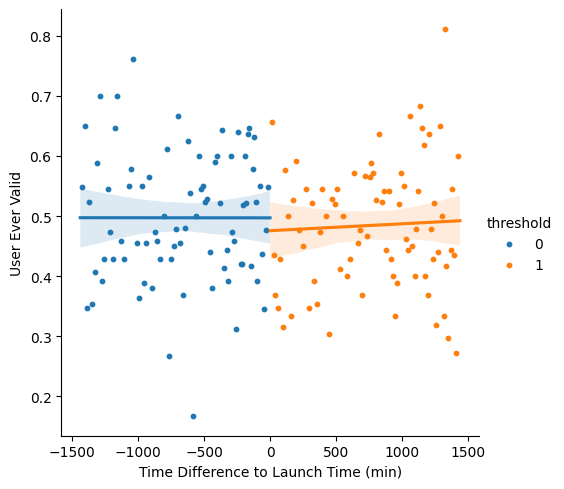

In [360]:
sns.lmplot(data=rdd_df_amed2, x="running_var", y="ever_live", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("User Ever Valid")

In [361]:
X = rdd_df_amed2[X_list]
X = sm.add_constant(X)
Y = rdd_df_amed2['match_success']

model5 = sm.OLS(Y, X).fit(cov_type='HC3')
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          match_success   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     160.2
Date:                Wed, 30 Aug 2023   Prob (F-statistic):               0.00
Time:                        08:12:17   Log-Likelihood:                -2309.9
No. Observations:                3422   AIC:                             4680.
Df Residuals:                    3392   BIC:                             4864.
Df Model:                          29                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2843      0.018     15.581      0.000       0.249       0.320
running_var      4.363e-06   2.75e-05      0.159      0.874   -4.94e-05    5.82e-05
threshold           0.0330      0.032      1.021      0.307      -0.030       0.096
interact        -5.698e-05   3.84e-05     -1.483      0.138      -0.000    1.83e-05
mul2                0.0859      0.019      4.620      0.000       0.049       0.122
cty_TW              0.0556      0.038      1.470      0.142      -0.019       0.130
pla_ANDROID         0.0720      0.012      5.895      0.000       0.048       0.096
pla_IOS             0.2123      0.015     14.444      0.000       0.183       0.241
uap_B&K             0.1182      0.035      3.421      0.001       0.050       0.186
uap_Home            0.0516      0.021      2.469      0.014       0.011       0.093
uap_Mix B&K         0.0342      0.129      0.266      0.791      -0.218       0.287
uap_Mix HB&K        0.0901      0.058      1.564      0.118      -0.023       0.203
uap_Mix HP          0.0329      0.076      0.430      0.667      -0.117       0.183
uap_Mix Home        0.0389      0.030      1.295      0.195      -0.020       0.098
uap_Mix Other       0.1647      0.337      0.489      0.625      -0.496       0.825
uap_Mix PB&K        0.1000      0.183      0.546      0.585      -0.259       0.459
uap_Mix Pet         0.1348      0.098      1.378      0.168      -0.057       0.326
uap_Other           0.0135      0.037      0.370      0.711      -0.058       0.085
uap_Pet             0.1882      0.041      4.627      0.000       0.108       0.268
clo_baby_room       0.2733      0.088      3.120      0.002       0.102       0.445
clo_back_door       0.0003      0.106      0.003      0.997      -0.207       0.208
clo_bedroom         0.3239      0.031     10.402      0.000       0.263       0.385
clo_driveway        0.3096      0.090      3.448      0.001       0.134       0.486
clo_front_door      0.2143      0.047      4.558      0.000       0.122       0.306
clo_garage          0.1415      0.092      1.546      0.122      -0.038       0.321
clo_kitchen         0.2304      0.071      3.255      0.001       0.092       0.369
clo_living_room     0.2017      0.045      4.448      0.000       0.113       0.291
clo_office          0.1780      0.101      1.757      0.079      -0.021       0.377
clo_store           0.5624      0.056     10.056      0.000       0.453       0.672
clo_street          0.2412      0.089      2.700      0.007       0.066       0.416
clo_yard            0.3235      0.058      5.535      0.000       0.209       0.438
==============================================================================
Omnibus:                    15024.925   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            

In [362]:
!pip install linearmodels

In [363]:
from linearmodels import IV2SLS

rdd_df_amed2['const'] = 1

X_list =['const', 'running_var','interact','mul2', 'cty_TW', 'pla_ANDROID', 'uap_B&K', 'uap_Home',	'uap_Mix B&K',	'uap_Mix HB&K',
         'uap_Mix HP',	'uap_Mix Home',	'uap_Mix Other',	'uap_Mix PB&K',	'uap_Mix Pet',	'uap_Other',	'uap_Pet', 'clo_baby_room',	'clo_back_door',
         'clo_bedroom',	'clo_driveway',	'clo_front_door',	'clo_garage',	'clo_kitchen',	'clo_living_room',	'clo_office',	'clo_store',	'clo_street',
         'clo_yard']

dep = rdd_df_amed2['match_success']
exog = rdd_df_amed2[X_list]
endog = rdd_df_amed2[['cli_add_alfredcam']]
instr = rdd_df_amed2[['threshold']]

match_success = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
match_success.summary


<ipython-input-363-9e9e43645adb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_amed2['const'] = 1


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:          match_success   R-squared:                      0.0190
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0107
No. Observations:                3422   F-statistic:                    516.95
Date:                Wed, Aug 30 2023   P-value (F-stat)                0.0000
Time:                        08:12:22   Distribution:                 chi2(29)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 0.5094     0.0282     18.054     0.0000      0.4541      0.5647
running_var        4.054e-06  2.742e-05     0.1478     0.8825  -4.969e-05    5.78e-05
interact          -7.166e-05  4.335e-05    -1.6532     0.0983     -0.0002    1.33e-05
mul2                  0.0974     0.0218     4.4718     0.0000      0.0547      0.1401
cty_TW                0.0594     0.0390     1.5230     0.1278     -0.0170      0.1358
pla_ANDROID          -0.1574     0.0272    -5.7831     0.0000     -0.2108     -0.1041
uap_B&K               0.1076     0.0366     2.9354     0.0033      0.0357      0.1794
uap_Home              0.0428     0.0235     1.8226     0.0684     -0.0032      0.0887
uap_Mix B&K           0.0470     0.1205     0.3899     0.6966     -0.1892      0.2832
uap_Mix HB&K          0.0883     0.0587     1.5024     0.1330     -0.0269      0.2034
uap_Mix HP            0.0372     0.0774     0.4801     0.6311     -0.1146      0.1890
uap_Mix Home          0.0345     0.0314     1.0995     0.2716     -0.0270      0.0961
uap_Mix Other         0.1747     0.2234     0.7821     0.4341     -0.2632      0.6126
uap_Mix PB&K          0.1090     0.1587     0.6870     0.4921     -0.2021      0.4201
uap_Mix Pet           0.1540     0.0969     1.5902     0.1118     -0.0358      0.3439
uap_Other             0.0030     0.0390     0.0772     0.9384     -0.0734      0.0794
uap_Pet               0.1901     0.0419     4.5363     0.0000      0.1080      0.2722
clo_baby_room         0.3044     0.0864     3.5247     0.0004      0.1351      0.4737
clo_back_door         0.0143     0.1007     0.1415     0.8875     -0.1831      0.2116
clo_bedroom           0.3269     0.0318     10.269     0.0000      0.2645      0.3893
clo_driveway          0.3359     0.0895     3.7536     0.0002      0.1605      0.5113
clo_front_door        0.2256     0.0479     4.7085     0.0000      0.1317      0.3195
clo_garage            0.1414     0.0852     1.6598     0.0969     -0.0256      0.3084
clo_kitchen           0.2390     0.0677     3.5283     0.0004      0.1062      0.3717
clo_living_room       0.2146     0.0468     4.5861     0.0000      0.1229      0.3063
clo_office            0.1261     0.1081     1.1667     0.2433     -0.0857      0.3380
clo_store             0.5896     0.0613     9.6202     0.0000      0.4695      0.7097
clo_street            0.2780     0.0907     3.0651     0.0022      0.1002      0.4558
clo_yard              0.3280     0.0555     5.9057     0.0000      0.2192      0.4369
cli_add_alfredcam     0.5151     0.5158     0.9987     0.3179     -0.4958      1.5260
=====================================================================================

Endogenous: cli_add_alfredcam
Instruments: threshold
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [364]:
rdd_df_amed2['freq'] = rdd_df_amed2.groupby('click')['UId'].transform('count') / len(rdd_df_amed2)
match_success_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed2['freq']).fit(cov_type = 'robust')
match_success_w.summary

<ipython-input-364-0a14ef7229cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_amed2['freq'] = rdd_df_amed2.groupby('click')['UId'].transform('count') / len(rdd_df_amed2)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:          match_success   R-squared:                     -0.7689
Estimator:                    IV-2SLS   Adj. R-squared:                -0.7840
No. Observations:                3422   F-statistic:                    162.10
Date:                Wed, Aug 30 2023   P-value (F-stat)                0.0000
Time:                        08:12:22   Distribution:                 chi2(29)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 0.6766     0.1822     3.7133     0.0002      0.3195      1.0337
running_var           0.0002     0.0001     1.4687     0.1419  -6.486e-05      0.0005
interact           -7.57e-05     0.0002    -0.3356     0.7372     -0.0005      0.0004
mul2                 -0.5240     0.2324    -2.2545     0.0242     -0.9795     -0.0685
cty_TW                0.2440     0.1035     2.3575     0.0184      0.0411      0.4468
pla_ANDROID          -0.0226     0.1045    -0.2159     0.8290     -0.2275      0.1823
uap_B&K              -0.2015     0.2178    -0.9249     0.3550     -0.6284      0.2255
uap_Home              0.0503     0.1406     0.3576     0.7206     -0.2253      0.3259
uap_Mix B&K          -0.2485     0.1949    -1.2753     0.2022     -0.6304      0.1334
uap_Mix HB&K          0.1247     0.1573     0.7930     0.4278     -0.1835      0.4330
uap_Mix HP           -0.2035     0.1975    -1.0301     0.3030     -0.5906      0.1837
uap_Mix Home          0.1929     0.1410     1.3680     0.1713     -0.0835      0.4692
uap_Mix Other         0.3681     0.4114     0.8948     0.3709     -0.4382      1.1744
uap_Mix PB&K          0.0464     0.2604     0.1782     0.8586     -0.4639      0.5567
uap_Mix Pet           0.0411     0.2056     0.2000     0.8415     -0.3618      0.4440
uap_Other            -0.1093     0.1773    -0.6163     0.5377     -0.4569      0.2383
uap_Pet               0.2398     0.1705     1.4064     0.1596     -0.0944      0.5740
clo_baby_room         0.1538     0.2951     0.5210     0.6024     -0.4247      0.7322
clo_back_door        -0.0351     0.1550    -0.2266     0.8208     -0.3390      0.2688
clo_bedroom           0.5776     0.1574     3.6703     0.0002      0.2692      0.8860
clo_driveway          0.0829     0.2600     0.3190     0.7498     -0.4267      0.5925
clo_front_door        0.1704     0.1162     1.4667     0.1424     -0.0573      0.3981
clo_garage            0.6624     0.3605     1.8377     0.0661     -0.0441      1.3689
clo_kitchen           0.2542     0.1714     1.4826     0.1382     -0.0818      0.5902
clo_living_room      -0.1292     0.2039    -0.6337     0.5263     -0.5288      0.2704
clo_office            0.7523     0.3751     2.0058     0.0449      0.0172      1.4874
clo_store             0.8562     0.1797     4.7635     0.0000      0.5039      1.2085
clo_street           -0.2517     0.2799    -0.8993     0.3685     -0.8003      0.2969
clo_yard              0.8628     0.1555     5.5497     0.0000      0.5581      1.1676
cli_add_alfredcam    -1.5787     0.8391    -1.8813     0.0599     -3.2233      0.0660
=====================================================================================

Endogenous: cli_add_alfredcam
Instruments: threshold
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [365]:
dep = rdd_df_amed2['ever_live']
ever_valid = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
ever_valid.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:              ever_live   R-squared:                      0.0366
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0284
No. Observations:                3422   F-statistic:                    566.93
Date:                Wed, Aug 30 2023   P-value (F-stat)                0.0000
Time:                        08:12:22   Distribution:                 chi2(29)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 0.5157     0.0280     18.412     0.0000      0.4608      0.5706
running_var        3.734e-06   2.74e-05     0.1363     0.8916  -4.996e-05   5.743e-05
interact            3.92e-05  4.283e-05     0.9153     0.3600  -4.475e-05      0.0001
mul2                 -0.1131     0.0215    -5.2589     0.0000     -0.1552     -0.0709
cty_TW               -0.0628     0.0388    -1.6195     0.1053     -0.1388      0.0132
pla_ANDROID           0.1278     0.0269     4.7444     0.0000      0.0750      0.1806
uap_B&K              -0.0809     0.0366    -2.2108     0.0270     -0.1526     -0.0092
uap_Home             -0.0279     0.0232    -1.1995     0.2303     -0.0734      0.0177
uap_Mix B&K          -0.0354     0.1175    -0.3011     0.7634     -0.2657      0.1950
uap_Mix HB&K         -0.1292     0.0585    -2.2077     0.0273     -0.2439     -0.0145
uap_Mix HP           -0.0705     0.0784    -0.8992     0.3686     -0.2242      0.0832
uap_Mix Home         -0.0310     0.0311    -0.9953     0.3196     -0.0920      0.0300
uap_Mix Other        -0.1713     0.2246    -0.7626     0.4457     -0.6115      0.2689
uap_Mix PB&K         -0.1019     0.1618    -0.6301     0.5286     -0.4190      0.2151
uap_Mix Pet          -0.1770     0.0970    -1.8253     0.0680     -0.3671      0.0131
uap_Other            -0.0111     0.0388    -0.2857     0.7751     -0.0872      0.0650
uap_Pet              -0.1649     0.0413    -3.9912     0.0001     -0.2459     -0.0839
clo_baby_room        -0.3215     0.0776    -4.1452     0.0000     -0.4736     -0.1695
clo_back_door        -0.1495     0.0744    -2.0082     0.0446     -0.2953     -0.0036
clo_bedroom          -0.3575     0.0265    -13.481     0.0000     -0.4094     -0.3055
clo_driveway         -0.4232     0.0625    -6.7726     0.0000     -0.5456     -0.3007
clo_front_door       -0.3001     0.0371    -8.1000     0.0000     -0.3727     -0.2275
clo_garage           -0.1553     0.0707    -2.1953     0.0281     -0.2939     -0.0166
clo_kitchen          -0.2168     0.0579    -3.7424     0.0002     -0.3303     -0.1032
clo_living_room      -0.2646     0.0396    -6.6812     0.0000     -0.3423     -0.1870
clo_office           -0.1213     0.1035    -1.1722     0.2411     -0.3241      0.0815
clo_store            -0.3601     0.2378    -1.5147     0.1299     -0.8261      0.1059
clo_street           -0.2825     0.0857    -3.2970     0.0010     -0.4505     -0.1146
clo_yard             -0.3006     0.0504    -5.9689     0.0000     -0.3993     -0.2019
cli_add_alfredcam    -0.4961     0.5126    -0.9677     0.3332     -1.5009      0.5087
=====================================================================================

Endogenous: cli_add_alfredcam
Instruments: threshold
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [366]:
ever_valid_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed2['freq']).fit(cov_type = 'robust')
ever_valid_w.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:              ever_live   R-squared:                     -0.7021
Estimator:                    IV-2SLS   Adj. R-squared:                -0.7167
No. Observations:                3422   F-statistic:                    208.39
Date:                Wed, Aug 30 2023   P-value (F-stat)                0.0000
Time:                        08:12:22   Distribution:                 chi2(29)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 0.3843     0.1911     2.0114     0.0443      0.0098      0.7588
running_var       -6.583e-05     0.0002    -0.4048     0.6856     -0.0004      0.0003
interact          -8.191e-05     0.0003    -0.3214     0.7479     -0.0006      0.0004
mul2                  0.4818     0.2373     2.0302     0.0423      0.0167      0.9468
cty_TW               -0.2339     0.1057    -2.2131     0.0269     -0.4410     -0.0267
pla_ANDROID           0.0324     0.1037     0.3127     0.7545     -0.1709      0.2357
uap_B&K               0.2176     0.2242     0.9707     0.3317     -0.2218      0.6570
uap_Home             -0.0845     0.1483    -0.5697     0.5689     -0.3751      0.2062
uap_Mix B&K           0.2625     0.1986     1.3221     0.1861     -0.1267      0.6517
uap_Mix HB&K         -0.2440     0.1659    -1.4708     0.1414     -0.5691      0.0812
uap_Mix HP            0.0845     0.2000     0.4228     0.6724     -0.3074      0.4765
uap_Mix Home         -0.2550     0.1435    -1.7774     0.0755     -0.5362      0.0262
uap_Mix Other        -0.4169     0.3999    -1.0424     0.2972     -1.2007      0.3669
uap_Mix PB&K         -0.0406     0.2602    -0.1561     0.8759     -0.5506      0.4694
uap_Mix Pet          -0.0728     0.2062    -0.3531     0.7240     -0.4769      0.3313
uap_Other             0.1001     0.1838     0.5443     0.5862     -0.2603      0.4604
uap_Pet              -0.2441     0.1701    -1.4354     0.1512     -0.5774      0.0892
clo_baby_room        -0.2263     0.2577    -0.8780     0.3799     -0.7313      0.2788
clo_back_door        -0.2894     0.1193    -2.4250     0.0153     -0.5232     -0.0555
clo_bedroom          -0.6252     0.1461    -4.2781     0.0000     -0.9117     -0.3388
clo_driveway         -0.1638     0.2149    -0.7624     0.4458     -0.5850      0.2574
clo_front_door       -0.2151     0.1016    -2.1172     0.0342     -0.4142     -0.0160
clo_garage           -0.6578     0.3517    -1.8700     0.0615     -1.3471      0.0316
clo_kitchen          -0.1606     0.1719    -0.9345     0.3500     -0.4974      0.1762
clo_living_room       0.0267     0.1909     0.1399     0.8887     -0.3474      0.4008
clo_office           -0.6340     0.3789    -1.6735     0.0942     -1.3765      0.1085
clo_store            -0.7936     0.2298    -3.4532     0.0006     -1.2441     -0.3432
clo_street            0.2156     0.2765     0.7796     0.4356     -0.3264      0.7575
clo_yard             -0.7009     0.1731    -4.0489     0.0001     -1.0401     -0.3616
cli_add_alfredcam     1.5533     0.8431     1.8424     0.0654     -0.0991      3.2057
=====================================================================================

Endogenous: cli_add_alfredcam
Instruments: threshold
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [367]:
from linearmodels.iv.results import compare
from collections import OrderedDict

an1 = OrderedDict()
an1["match_success"] = match_success
an1['match_success_weighted'] = match_success_w
an1["ever_valid"] = ever_valid
an1['ever_valid_weighted'] = ever_valid_w
print(compare(an1, precision='std_errors', stars=True))

                                         Model Comparison                                         
                          match_success match_success_weighted      ever_valid ever_valid_weighted
--------------------------------------------------------------------------------------------------
Dep. Variable             match_success          match_success       ever_live           ever_live
Estimator                       IV-2SLS                IV-2SLS         IV-2SLS             IV-2SLS
No. Observations                   3422                   3422            3422                3422
Cov. Est.                        robust                 robust          robust              robust
R-squared                        0.0190                -0.7689          0.0366             -0.7021
Adj. R-squared                   0.0107                -0.7840          0.0284             -0.7167
F-statistic                      516.95                 162.10          566.93              208.39
P-value (F

It seems like that
1. clicking in add AlfredCam marginally affects match success rate
2. clicking in add AlfredCam doesn't negatively affects valid rate in the longer terms

In [368]:
rdd_df_amed2['match_success_12h'] = (rdd_df_amed2['match_time_diff'] <= 720).astype(int)
rdd_df_amed2['match_success_24h'] = (rdd_df_amed2['match_time_diff'] <= 1440).astype(int)
rdd_df_amed2['ever_live_12h'] = (rdd_df_amed2['live_time_diff'] <= 720).astype(int)
rdd_df_amed2['ever_live_24h'] = (rdd_df_amed2['live_time_diff'] <= 1440).astype(int)

<ipython-input-368-d4f5e7d4fd6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_amed2['match_success_12h'] = (rdd_df_amed2['match_time_diff'] <= 720).astype(int)
<ipython-input-368-d4f5e7d4fd6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_amed2['match_success_24h'] = (rdd_df_amed2['match_time_diff'] <= 1440).astype(int)
<ipython-input-368-d4f5e7d4fd6e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [369]:
dep = rdd_df_amed2['ever_live_12h']
ever_valid_12h = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
ever_valid_12h_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed2['freq']).fit(cov_type = 'robust')


dep = rdd_df_amed2['ever_live_24h']
ever_valid_24h = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
ever_valid_24h_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed2['freq']).fit(cov_type = 'robust')

an2 = OrderedDict()
an2["ever_live_12h"] = ever_valid_12h
an2['12h_weighted'] = ever_valid_12h_w
an2["ever_live_24h"] = ever_valid_24h
an2['24h_weighted'] = ever_valid_24h_w
print(compare(an2, precision='std_errors', stars=True))

                                       Model Comparison                                      
                          ever_live_12h      12h_weighted     ever_live_24h      24h_weighted
---------------------------------------------------------------------------------------------
Dep. Variable             ever_live_12h     ever_live_12h     ever_live_24h     ever_live_24h
Estimator                       IV-2SLS           IV-2SLS           IV-2SLS           IV-2SLS
No. Observations                   3422              3422              3422              3422
Cov. Est.                        robust            robust            robust            robust
R-squared                        0.0547           -0.4521            0.0708           -0.3742
Adj. R-squared                   0.0466           -0.4645            0.0628           -0.3859
F-statistic                      185.17            128.53            216.87            143.39
P-value (F-stat)                 0.0000         1.721e-14   

In [370]:
dep = rdd_df_amed2['match_success_12h']
match_success_12h = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
match_success_12h_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed2['freq']).fit(cov_type = 'robust')


dep = rdd_df_amed2['match_success_24h']
match_success_24h = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
match_success_24h_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed2['freq']).fit(cov_type = 'robust')

an3 = OrderedDict()
an3["match_success_12h"] = match_success_12h
an3['12h_weighted'] = match_success_12h_w
an3["match_success_24h"] = match_success_24h
an3['24h_weighted'] = match_success_24h_w
print(compare(an3, precision='std_errors', stars=True))

                                               Model Comparison                                              
                          match_success_12h          12h_weighted     match_success_24h          24h_weighted
-------------------------------------------------------------------------------------------------------------
Dep. Variable             match_success_12h     match_success_12h     match_success_24h     match_success_24h
Estimator                           IV-2SLS               IV-2SLS               IV-2SLS               IV-2SLS
No. Observations                       3422                  3422                  3422                  3422
Cov. Est.                            robust                robust                robust                robust
R-squared                            0.0706               -0.2666                0.0750               -0.2801
Adj. R-squared                       0.0626               -0.2774                0.0671               -0.2910
F-statisti

robustness check: changing definition for clicking AlfredCam

In [371]:
rdd_df_a2 = rdd_df[~(rdd_df['alfredcam_click_1d'].isnull())]
rdd_df_a2['alfredcam_click_1d'] = rdd_df_a2['alfredcam_click_1d'].astype(int)
rdd_df_a2['ever_click_alfredCam_1d'] = (rdd_df_a2['alfredcam_click_1d']>0)

rdd_df_a2['const'] = 1
dep = rdd_df_a2['match_success']
exog = rdd_df_a2[X_list]
endog = rdd_df_a2[['ever_click_alfredCam_1d']]
instr = rdd_df_a2[['threshold']]

<ipython-input-371-2238aa30cc3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_a2['alfredcam_click_1d'] = rdd_df_a2['alfredcam_click_1d'].astype(int)
<ipython-input-371-2238aa30cc3c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_a2['ever_click_alfredCam_1d'] = (rdd_df_a2['alfredcam_click_1d']>0)
<ipython-input-371-2238aa30cc3c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [372]:
rdd_df_a2['match_success_12h'] = (rdd_df_a2['match_time_diff'] <= 720).astype(int)
rdd_df_a2['match_success_24h'] = (rdd_df_a2['match_time_diff'] <= 1440).astype(int)
rdd_df_a2['ever_live_12h'] = (rdd_df_a2['live_time_diff'] <= 720).astype(int)
rdd_df_a2['ever_live_24h'] = (rdd_df_a2['live_time_diff'] <= 1440).astype(int)

match_success_e = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
dep = rdd_df_a2['match_success_12h']
match_success_12h_e = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
dep = rdd_df_a2['match_success_24h']
match_success_24h_e = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
dep = rdd_df_a2['ever_live']
ever_valid_e = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
dep = rdd_df_a2['ever_live_12h']
ever_valid_12h_e = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
dep = rdd_df_a2['ever_live_12h']
ever_valid_24h_e = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')


<ipython-input-372-e664aaf77284>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_a2['match_success_12h'] = (rdd_df_a2['match_time_diff'] <= 720).astype(int)
<ipython-input-372-e664aaf77284>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_a2['match_success_24h'] = (rdd_df_a2['match_time_diff'] <= 1440).astype(int)
<ipython-input-372-e664aaf77284>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [373]:
an4 = OrderedDict()
an4["match_success"] = match_success_e
an4["match_success_12h"] = match_success_12h_e
an4['match_success_24h'] = match_success_24h_e
an4["ever_valid"] = ever_valid_e
an4["ever_valid_12h"] = ever_valid_12h_e
an4['ever_valid_24h'] = ever_valid_24h_e
print(compare(an4, precision='std_errors', stars=True))

                                                               Model Comparison                                                              
                                match_success     match_success_12h     match_success_24h      ever_valid    ever_valid_12h    ever_valid_24h
---------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                   match_success     match_success_12h     match_success_24h       ever_live     ever_live_12h     ever_live_12h
Estimator                             IV-2SLS               IV-2SLS               IV-2SLS         IV-2SLS           IV-2SLS           IV-2SLS
No. Observations                         3705                  3705                  3705            3705              3705              3705
Cov. Est.                              robust                robust                robust          robust            robust            robust
R-squa

tracting behavior per half-day, we see that
1. user who clicked in add alfredcam are less likely to finishing matching process timely
2. user who clicked in add alfredcam are less likely to start their first live timely

Remarks:
1. The treatment (changing layout) increases the chance for users to click Add AlfredCam button
2. Users who clicked AlfredCam bottons shows trends that
  1. less likely to finishing parining the device, no matter in a given amount of time or in the longer run
  2. less likely to start their first live session timely, yet, it does not seem to affects the long term valid rate - this

These results suggest that:
1. the current onboarding process does impede conversion
2. if our hypothesis is to let users to get wowed as quick as possible, the current setting is against our goal

# Main Analysis - Check for Finishing Time

As time to the first live/to the first successiful match all conditional on previous moves, the following findings are less likely to be able to be interpreted as causal (given that the layout alters valid behavior).

Also, as finishing time conditional on valid, the sample of the following results will be further constrained to valid users.


In [374]:
rdd_df_amed3 = rdd_df_amed2[(~rdd_df_amed2['live_time_diff'].isnull())]
rdd_df_amed3 = rdd_df_amed3[~(rdd_df_amed3['alfredcam_click_1d'].isnull())]
rdd_df_amed3['alfredcam_click_1d'] = rdd_df_amed3['alfredcam_click_1d'].astype(int)
rdd_df_amed3['ever_click_alfredCam_1d'] = (rdd_df_amed3['alfredcam_click_1d']>0)

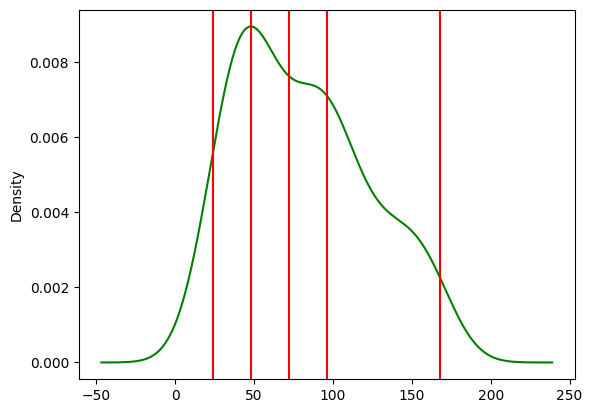

In [375]:
# check for the time distribution
over24 = rdd_df_amed3[rdd_df_amed3['match_time_diff'] > 86400]['match_time_diff']
ax = (over24/3600).plot.density(color='green')
ax.axvline(x=24, color='red', linestyle='-', label='x=24')
ax.axvline(x=48, color='red', linestyle='-', label='x=48')
ax.axvline(x=72, color='red', linestyle='-', label='x=48')
ax.axvline(x=96, color='red', linestyle='-', label='x=48')
ax.axvline(x=168, color='red', linestyle='-', label='x=48')

In [376]:
(over24/3600).describe()

count     79.000000
mean      81.110614
std       41.171648
min       24.589622
25%       46.425645
50%       74.627579
75%      108.043410
max      167.519420
Name: match_time_diff, dtype: float64

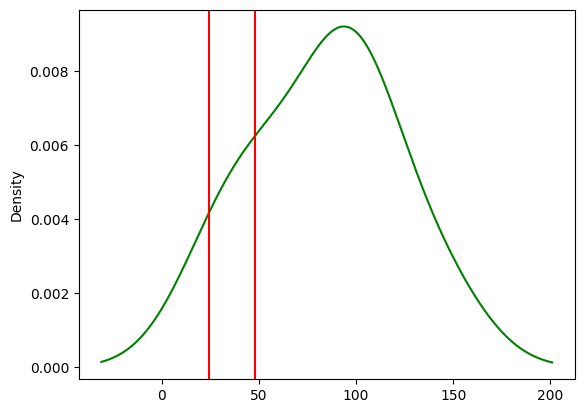

In [377]:
over24_alfredcam = rdd_df_amed3[(rdd_df_amed3['match_time_diff'] > 86400) & (rdd_df_amed3['alfredcam_click_1d'])]['match_time_diff']
ax = (over24_alfredcam/3600).plot.density(color='green')
ax.axvline(x=24, color='red', linestyle='-', label='x=24')
ax.axvline(x=48, color='red', linestyle='-', label='x=48')

In [378]:
(over24_alfredcam/3600).describe()

count      8.000000
mean      83.794015
std       37.318052
min       26.857928
25%       57.705780
50%       93.456654
75%      100.200781
max      142.951193
Name: match_time_diff, dtype: float64

In [379]:
# sidenote: the only user that first click alfredCam and match over 24h -> spent 122 hrs to have first pairing

In [380]:
dep = rdd_df_amed3['match_time_diff']
exog = rdd_df_amed3[X_list]
endog = rdd_df_amed3[['alfredcam_click_1d']]
instr = rdd_df_amed3[['threshold']]
rdd_df_amed3['freq'] = rdd_df_amed3.groupby('click')['UId'].transform('count') / len(rdd_df_amed3)

mtd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
mtd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed3['freq']).fit(cov_type = 'robust')

dep = rdd_df_amed3['live_time_diff']
ltd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
ltd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed3['freq']).fit(cov_type = 'robust')

an5 = OrderedDict()
an5["match_time_diff"] = mtd
an5['match_time_diff_weighted'] = mtd_w
an5["live_time_diff"] = ltd
an5['live_time_diff_weighted'] = ltd_w
print(compare(an5, precision='std_errors', stars=True))

/usr/local/lib/python3.10/dist-packages/linearmodels/iv/model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
/usr/local/lib/python3.10/dist-packages/linearmodels/iv/model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(


                                               Model Comparison                                               
                           match_time_diff match_time_diff_weighted     live_time_diff live_time_diff_weighted
--------------------------------------------------------------------------------------------------------------
Dep. Variable              match_time_diff          match_time_diff     live_time_diff          live_time_diff
Estimator                          IV-2SLS                  IV-2SLS            IV-2SLS                 IV-2SLS
No. Observations                      1550                     1550               1569                    1569
Cov. Est.                           robust                   robust             robust                  robust
R-squared                          -0.4834                   0.4939             0.0347                  0.3198
Adj. R-squared                     -0.5117                   0.4843             0.0165                  0.3070
F

In [381]:
dep = np.log(rdd_df_amed3['match_time_diff'])
exog = rdd_df_amed3[X_list]
endog = rdd_df_amed3[['alfredcam_click_1d']]
instr = rdd_df_amed3[['threshold']]
rdd_df_amed3['freq'] = rdd_df_amed3.groupby('click')['UId'].transform('count') / len(rdd_df_amed3)

mtd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
mtd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed3['freq']).fit(cov_type = 'robust')

dep = np.log(rdd_df_amed3['live_time_diff'])
ltd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
ltd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed3['freq']).fit(cov_type = 'robust')

an5a = OrderedDict()
an5a["match_time_diff"] = mtd
an5a['match_time_diff_weighted'] = mtd_w
an5a["live_time_diff"] = ltd
an5a['live_time_diff_weighted'] = ltd_w
print(compare(an5a, precision='std_errors', stars=True))

/usr/local/lib/python3.10/dist-packages/linearmodels/iv/model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
/usr/local/lib/python3.10/dist-packages/linearmodels/iv/model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(


                                               Model Comparison                                               
                           match_time_diff match_time_diff_weighted     live_time_diff live_time_diff_weighted
--------------------------------------------------------------------------------------------------------------
Dep. Variable              match_time_diff          match_time_diff     live_time_diff          live_time_diff
Estimator                          IV-2SLS                  IV-2SLS            IV-2SLS                 IV-2SLS
No. Observations                      1550                     1550               1569                    1569
Cov. Est.                           robust                   robust             robust                  robust
R-squared                          -0.1200                   0.3359            -0.0385                  0.3529
Adj. R-squared                     -0.1414                   0.3232            -0.0581                  0.3408
F

In [382]:
dep = np.log(rdd_df_amed3['match_time_diff'])
endog = rdd_df_amed3[['ever_click_alfredCam_1d']]
mtd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
mtd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed3['freq']).fit(cov_type = 'robust')

dep = rdd_df_amed3['live_time_diff']
ltd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
ltd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed3['freq']).fit(cov_type = 'robust')

an5c = OrderedDict()
an5c["match_time_diff"] = mtd
an5c['match_time_diff_weighted'] = mtd_w
an5c["live_time_diff"] = ltd
an5c['live_time_diff_weighted'] = ltd_w
print(compare(an5c, precision='std_errors', stars=True))

/usr/local/lib/python3.10/dist-packages/linearmodels/iv/model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
/usr/local/lib/python3.10/dist-packages/linearmodels/iv/model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(


                                                  Model Comparison                                                 
                                match_time_diff match_time_diff_weighted     live_time_diff live_time_diff_weighted
-------------------------------------------------------------------------------------------------------------------
Dep. Variable                   match_time_diff          match_time_diff     live_time_diff          live_time_diff
Estimator                               IV-2SLS                  IV-2SLS            IV-2SLS                 IV-2SLS
No. Observations                           1550                     1550               1569                    1569
Cov. Est.                                robust                   robust             robust                  robust
R-squared                                0.0002                   0.3347             0.0398                  0.3260
Adj. R-squared                          -0.0189                   0.3220

In [383]:
rdd_df_amed4 = rdd_df_amed2[(~rdd_df_amed2['match_time_diff'].isnull())]
rdd_df_amed4 = rdd_df_amed4[~(rdd_df_amed4['alfredcam_click_1d'].isnull())]
rdd_df_amed4['alfredcam_click_1d'] = rdd_df_amed4['alfredcam_click_1d'].astype(int)
rdd_df_amed4['ever_click_alfredCam_1d'] = (rdd_df_amed4['alfredcam_click_1d']>0)

In [384]:
dep = rdd_df_amed4['match_time_diff']
exog = rdd_df_amed4[X_list]
endog = rdd_df_amed4[['alfredcam_click_1d']]
instr = rdd_df_amed4[['threshold']]
rdd_df_amed4['freq'] = rdd_df_amed4.groupby('click')['UId'].transform('count') / len(rdd_df_amed4)

mtd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
mtd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed4['freq']).fit(cov_type = 'robust')

an6 = OrderedDict()
an6["match_time_diff"] = mtd
an6['match_time_diff_weighted'] = mtd_w
print(compare(an6, precision='std_errors', stars=True))

                          Model Comparison                         
                           match_time_diff match_time_diff_weighted
-------------------------------------------------------------------
Dep. Variable              match_time_diff          match_time_diff
Estimator                          IV-2SLS                  IV-2SLS
No. Observations                      1698                     1698
Cov. Est.                           robust                   robust
R-squared                          -0.4141                   0.4957
Adj. R-squared                     -0.4387                   0.4869
F-statistic                         102.68                   81.904
P-value (F-stat)                 3.627e-10                6.078e-07
====================     =================        =================
const                           1.215e+04*                1.702e+04
                                  (6968.4)              (1.852e+04)
running_var                        -6.9449      

In [385]:
dep = np.log(rdd_df_amed4['match_time_diff'])
exog = rdd_df_amed4[X_list]
endog = rdd_df_amed4[['alfredcam_click_1d']]
instr = rdd_df_amed4[['threshold']]
rdd_df_amed4['freq'] = rdd_df_amed4.groupby('click')['UId'].transform('count') / len(rdd_df_amed4)

mtd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
mtd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed4['freq']).fit(cov_type = 'robust')

an6 = OrderedDict()
an6["match_time_diff"] = mtd
an6['match_time_diff_weighted'] = mtd_w
print(compare(an6, precision='std_errors', stars=True))

                          Model Comparison                         
                           match_time_diff match_time_diff_weighted
-------------------------------------------------------------------
Dep. Variable              match_time_diff          match_time_diff
Estimator                          IV-2SLS                  IV-2SLS
No. Observations                      1698                     1698
Cov. Est.                           robust                   robust
R-squared                          -0.0829                   0.3488
Adj. R-squared                     -0.1017                   0.3374
F-statistic                         114.65                   146.75
P-value (F-stat)                 3.904e-12                   0.0000
====================     =================        =================
const                            5.3255***                5.1098***
                                  (0.2402)                 (0.5839)
running_var                        -0.0003      

In [386]:
dep = np.log(rdd_df_amed4['match_time_diff'])
exog = rdd_df_amed4[X_list]
endog = rdd_df_amed4[['ever_click_alfredCam_1d']]
instr = rdd_df_amed4[['threshold']]
rdd_df_amed4['freq'] = rdd_df_amed4.groupby('click')['UId'].transform('count') / len(rdd_df_amed4)

mtd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
mtd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed4['freq']).fit(cov_type = 'robust')

an6 = OrderedDict()
an6["match_time_diff"] = mtd
an6['match_time_diff_weighted'] = mtd_w
print(compare(an6, precision='std_errors', stars=True))

                            Model Comparison                            
                                match_time_diff match_time_diff_weighted
------------------------------------------------------------------------
Dep. Variable                   match_time_diff          match_time_diff
Estimator                               IV-2SLS                  IV-2SLS
No. Observations                           1698                     1698
Cov. Est.                                robust                   robust
R-squared                                0.0143                   0.3486
Adj. R-squared                          -0.0028                   0.3373
F-statistic                              123.26                   146.53
P-value (F-stat)                      1.374e-13                   0.0000
=========================     =================        =================
const                                 5.4602***                5.1128***
                                       (0.2062)    

The new layout doesn't seem to change the time to valid by much. Yet this result could be driven by the previous result: Since we lose some of the users in the matching phase, we're unable to record the correct finishing time (had them not left). The surviving users might be very similar to each other and thus the completing time is not differeing.

On the other hand, adding the extra button does seem to affect the finishing time for pairing a new device

In [387]:
dep = rdd_df_amed3['match_time_diff']
exog = rdd_df_amed3[X_list]
endog = rdd_df_amed3[['cli_add_alfredcam']]
instr = rdd_df_amed3[['threshold']]
rdd_df_amed3['freq'] = rdd_df_amed3.groupby('click')['UId'].transform('count') / len(rdd_df_amed3)

mtd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
mtd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed3['freq']).fit(cov_type = 'robust')

dep = rdd_df_amed3['live_time_diff']
ltd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
ltd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed3['freq']).fit(cov_type = 'robust')

an5d = OrderedDict()
an5d["match_time_diff"] = mtd
an5d['match_time_diff_weighted'] = mtd_w
an5d["live_time_diff"] = ltd
an5d['live_time_diff_weighted'] = ltd_w
print(compare(an5d, precision='std_errors', stars=True))

/usr/local/lib/python3.10/dist-packages/linearmodels/iv/model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
/usr/local/lib/python3.10/dist-packages/linearmodels/iv/model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(


                                               Model Comparison                                              
                          match_time_diff match_time_diff_weighted     live_time_diff live_time_diff_weighted
-------------------------------------------------------------------------------------------------------------
Dep. Variable             match_time_diff          match_time_diff     live_time_diff          live_time_diff
Estimator                         IV-2SLS                  IV-2SLS            IV-2SLS                 IV-2SLS
No. Observations                     1550                     1550               1569                    1569
Cov. Est.                          robust                   robust             robust                  robust
R-squared                         -0.7225                   0.4975             0.0277                  0.3223
Adj. R-squared                    -0.7553                   0.4879             0.0094                  0.3096
F-statisti

In [388]:
dep = np.log(rdd_df_amed3['match_time_diff'])
exog = rdd_df_amed3[X_list]
endog = rdd_df_amed3[['cli_add_alfredcam']]
instr = rdd_df_amed3[['threshold']]
rdd_df_amed3['freq'] = rdd_df_amed3.groupby('click')['UId'].transform('count') / len(rdd_df_amed3)

mtd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
mtd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed3['freq']).fit(cov_type = 'robust')

dep = np.log(rdd_df_amed3['live_time_diff'])
ltd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
ltd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed3['freq']).fit(cov_type = 'robust')

an5b = OrderedDict()
an5b["match_time_diff"] = mtd
an5b['match_time_diff_weighted'] = mtd_w
an5b["live_time_diff"] = ltd
an5b['live_time_diff_weighted'] = ltd_w
print(compare(an5b, precision='std_errors', stars=True))

/usr/local/lib/python3.10/dist-packages/linearmodels/iv/model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
/usr/local/lib/python3.10/dist-packages/linearmodels/iv/model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(


                                               Model Comparison                                              
                          match_time_diff match_time_diff_weighted     live_time_diff live_time_diff_weighted
-------------------------------------------------------------------------------------------------------------
Dep. Variable             match_time_diff          match_time_diff     live_time_diff          live_time_diff
Estimator                         IV-2SLS                  IV-2SLS            IV-2SLS                 IV-2SLS
No. Observations                     1550                     1550               1569                    1569
Cov. Est.                          robust                   robust             robust                  robust
R-squared                         -0.2672                   0.3338            -0.1375                  0.3477
Adj. R-squared                    -0.2914                   0.3211            -0.1590                  0.3354
F-statisti

In [389]:
dep = rdd_df_amed4['match_time_diff']
exog = rdd_df_amed4[['const', 'running_var', 'interact', 'mul2', 'cty_TW', 'pla_IOS', 'uap_B&K',	'uap_Home',	'uap_Mix B&K', 'uap_Mix HB&K', 'uap_Mix HP', 'uap_Mix Home', 'uap_Mix Other',	'uap_Mix PB&K',	'uap_Mix Pet', 'uap_Other',	'uap_Pet']]
endog = rdd_df_amed4[['cli_add_alfredcam']]
instr = rdd_df_amed4[['threshold']]
rdd_df_amed4['freq'] = rdd_df_amed4.groupby('click')['UId'].transform('count') / len(rdd_df_amed4)

mtd = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
mtd_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed4['freq']).fit(cov_type = 'robust')

an6 = OrderedDict()
an6["match_time_diff"] = mtd
an6['match_time_diff_weighted'] = mtd_w
print(compare(an6, precision='std_errors', stars=True))

                         Model Comparison                         
                          match_time_diff match_time_diff_weighted
------------------------------------------------------------------
Dep. Variable             match_time_diff          match_time_diff
Estimator                         IV-2SLS                  IV-2SLS
No. Observations                     1698                     1698
Cov. Est.                          robust                   robust
R-squared                         -0.6384                   0.3873
Adj. R-squared                    -0.6550                   0.3811
F-statistic                        55.861                   25.083
P-value (F-stat)                 4.98e-06                   0.0929
===================     =================        =================
const                         1.464e+04**               -2.752e+04
                                 (6368.8)              (2.618e+04)
running_var                       -5.8968                  -79

# Main Analysis - longterm churn / active Differences

In [390]:
rdd_df_amed4['last_online_time_7d'] = (((rdd_df_amed4['last_online'] - rdd_df['first_show_time'])).apply(lambda x: x.total_seconds())/3600).to_frame(name = 'last_online_time_7d')

Text(39.97004914158951, 0.5, 'Time Difference to Last Online Time (hrs)')

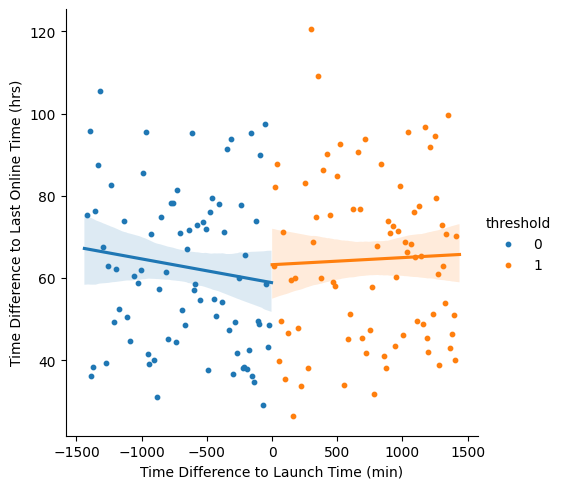

In [391]:
sns.lmplot(data=rdd_df_amed4, x="running_var", y="last_online_time_7d", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("Time Difference to Last Online Time (hrs)")

Text(39.30079566936729, 0.5, 'ever login within next 7 days')

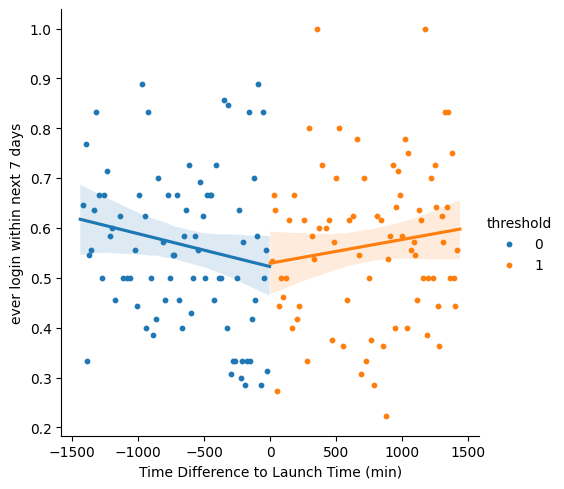

In [392]:
rdd_df_amed4['7d_churn'] = (rdd_df_amed4['last_online_time_7d'] > 24).astype(int)
sns.lmplot(data=rdd_df_amed4, x="running_var", y="7d_churn", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("ever login within next 7 days")

<ipython-input-393-190ed46dafac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_amed2['d7_churn'] = (~rdd_df_amed2['last_online'].isnull()).astype(int)


Text(39.30079566936729, 0.5, 'Time Difference to Last Online Time (min)')

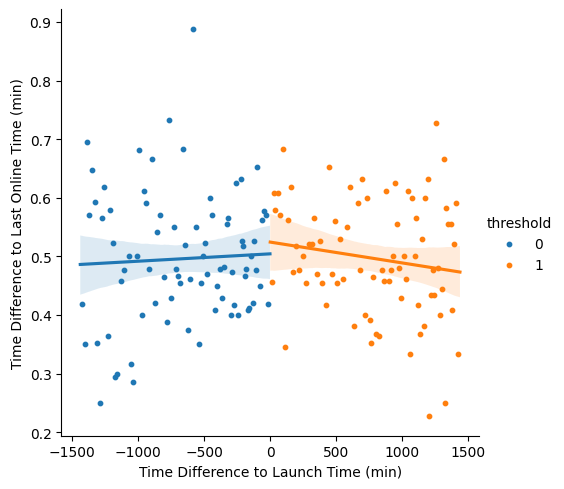

In [393]:
rdd_df_amed2['d7_churn'] = (~rdd_df_amed2['last_online'].isnull()).astype(int)
sns.lmplot(data=rdd_df_amed2, x="running_var", y="d7_churn", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("Time Difference to Last Online Time (min)")

In [394]:
dep = rdd_df_amed2['d7_churn']
exog = rdd_df_amed2[X_list]
endog = rdd_df_amed2[['cli_add_alfredcam']]
instr = rdd_df_amed2[['threshold']]

# after clicking

d7_churn = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
d7_churn_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed2['freq']).fit(cov_type = 'robust')

an7 = OrderedDict()
an7["d7_churn"] = d7_churn
an7['d7_churn_w'] = d7_churn_w

print(compare(an7, precision='std_errors', stars=True))

                  Model Comparison                 
                             d7_churn    d7_churn_w
---------------------------------------------------
Dep. Variable                d7_churn      d7_churn
Estimator                     IV-2SLS       IV-2SLS
No. Observations                 3422          3422
Cov. Est.                      robust        robust
R-squared                      0.0190       -0.7689
Adj. R-squared                 0.0107       -0.7840
F-statistic                    516.95        162.10
P-value (F-stat)               0.0000        0.0000
===================     =============   ===========
const                       0.5094***     0.6766***
                             (0.0282)      (0.1822)
running_var                 4.054e-06        0.0002
                          (2.742e-05)      (0.0001)
interact                  -7.166e-05*     -7.57e-05
                          (4.335e-05)      (0.0002)
mul2                        0.0974***     -0.5240**
            

In [395]:
rdd_df_amed2['subs'] = (~rdd_df_amed2['TimeFirstSubscribe'].isnull())
dep = rdd_df_amed2['subs']

subs = IV2SLS(dep, exog, endog, instr).fit(cov_type = 'robust')
subs_w = IV2SLS(dep, exog, endog, instr, weights = 1/rdd_df_amed2['freq']).fit(cov_type = 'robust')

an8 = OrderedDict()
an8["subs"] = subs
an8['subs_w'] = subs_w
print(compare(an8, precision='std_errors', stars=True))

<ipython-input-395-8747fd561ace>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_df_amed2['subs'] = (~rdd_df_amed2['TimeFirstSubscribe'].isnull())


                   Model Comparison                  
                                 subs          subs_w
-----------------------------------------------------
Dep. Variable                    subs            subs
Estimator                     IV-2SLS         IV-2SLS
No. Observations                 3422            3422
Cov. Est.                      robust          robust
R-squared                      0.0867          0.0645
Adj. R-squared                 0.0789          0.0566
F-statistic                    140.14          63.845
P-value (F-stat)             1.11e-16          0.0002
===================     =============   =============
const                       0.0502***        0.0408**
                             (0.0112)        (0.0163)
running_var                 1.135e-05       1.454e-05
                          (1.114e-05)     (1.065e-05)
interact                   -1.909e-05      -3.061e-06
                          (1.583e-05)     (1.561e-05)
mul2                        

# Additional Check For Bandwidth

In [396]:
rdd_df_amed3[rdd_df_amed3['cli_add_alfredcam'] > 0]

,UId,usage_purpose,location,lang,country,FirstPlatform,FirstVersion,FirstPlatformViewer,FirstVersionViewer,reg_time,TimeFirstLive,TimeFirstLive_s,TimeFirstSubscribe,click,Platform,first_show_time,second_show_time,SessionId,second_show_sid,click_time,two_show_gap,time_stay_on_page,f0_,slc_30m_rev,last_online,mobile_click,alfredcam_click,web_click,set_later_click,slc_30m_scv,clc_30m_clcs,time_account_first_multi,mat_compl,mobile_click_1d,alfredcam_click_1d,web_click_1d,set_later_click_1d,clc_1d_clcs,pla_ANDROID,pla_IOS,cty_TW,cty_US,lan_ar,lan_de,lan_el,lan_en,lan_en-US,lan_en_US,lan_es,lan_fa,lan_fr,lan_gu,lan_ha,lan_he,lan_hi,lan_id,lan_in,lan_it,lan_iw,lan_ja,lan_kk,lan_ko,lan_ms,lan_my,lan_nl,lan_pt,lan_ru,lan_sq,lan_th,lan_tr,lan_uk,lan_uz,lan_vi,lan_zh,uap_B&K,uap_Home,uap_Mix B&K,uap_Mix HB&K,uap_Mix HP,uap_Mix Home,uap_Mix Other,uap_Mix PB&K,uap_Mix Pet,uap_Other,uap_Pet,uap_Unknown,clo_baby_room,clo_back_door,clo_bedroom,clo_driveway,clo_front_door,clo_garage,clo_kitchen,clo_living_room,clo_office,clo_store,clo_street,clo_yard,ver_2022_12_1,ver_2022_13_0,mul,mul2,running_var,cli_add_alfredcam,cli_add_mobile_device,cli_add_web_camera,cli_camera_list,cli_explore,cli_mobile_device,cli_more,cli_no_camera_yet_add_camera,cli_premium,cli_set_later,cli_switch_role,cli_web_camera,threshold,interact,click_time_diff,match_time_diff,match_success,live_time_diff,ever_live,freq,const,match_success_12h,match_success_24h,ever_live_12h,ever_live_24h,ever_click_alfredCam_1d
796,0b0da202,Home,[],en,US,ANDROID,2022.12.1,ANDROID,2022.12.1,2022-08-24 21:08:11,2022-08-24 21:14:31.306,2022-08-24 21:14:21.532012,NaT,add_alfredcam,ANDROID,2022-08-24 21:08:22.846001,2022-08-24 21:08:50.013004,1661375276,1661375276,2022-08-24 21:08:32.628001,0-0 0 0:0:27.167003,0-0 0 0:0:9.782,NaN,3,2022-08-24 21:16:26.431011,0,1,1,1,27,7,NaT,2022-08-24 21:11:53.925001,0,1,1,1,7,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,948.0,1,0,0,0,0,0,0,0,0,0,0,0,1,948.0,9.782000,211.079000,1,358.686011,0,0.022307,1,1,1,1,1,True
919,0cb7d76f,Mix Home,"[living_room, front_door, office]",en,US,ANDROID,2022.12.1,ANDROID,2022.12.1,2022-08-24 23:36:50,2022-08-25 00:48:41.378,2022-08-25 00:48:31.462023,NaT,add_alfredcam,ANDROID,2022-08-24 23:37:18.901002,2022-08-24 23:37:45.552001,1661384189,1661384189,2022-08-24 23:37:32.802002,0-0 0 0:0:26.650999,0-0 0 0:0:13.901,true,7,2022-08-29 02:22:37.991036,2,2,0,2,42,13,NaT,2022-08-25 00:47:30.961000,6,2,0,3,44,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1097.0,1,0,0,0,0,0,0,0,0,0,0,0,1,1097.0,13.901000,4212.059998,1,4272.561021,0,0.022307,1,0,0,0,0,True
928,0cf673f7,Home,[bedroom],es,US,ANDROID,2022.12.1,ANDROID,2022.12.1,2022-08-24 13:41:53,2022-08-24 14:13:32.748,2022-08-24 14:13:22.873022,NaT,add_alfredcam,ANDROID,2022-08-24 13:42:16.002001,2022-08-24 14:00:24.019010,1661348491,1661348491,2022-08-24 13:43:04.163002,0-0 0 0:18:8.017009,0-0 0 0:0:48.161001,NaN,7,2022-08-31 02:21:54.153011,2,2,1,1,124,24,NaT,2022-08-24 14:00:20.229000,2,3,1,1,179,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,502.0,1,0,0,0,0,0,0,0,0,0,0,0,1,502.0,48.161001,1084.226999,1,1866.871021,0,0.022307,1,0,1,0,0,True
1563,163e9d58,Unknown,[],en,US,ANDROID,2022.12.1,NaN,NaN,2022-08-24 06:57:52,2022-08-24 07:01:19.002,2022-08-24 07:01:09.279005,NaT,add_alfredcam,ANDROID,2022-08-24 06:58:15.834001,2022-08-24 06:58:40.695012,1661324251,1661324251,2022-08-24 06:58:26.663004,0-0 0 0:0:24.861011,0-0 0 0:0:10.829003,true,5,2022-08-24 07:04:27.306003,2,2,0,0,79,25,2022-08-24 07:05:33,2022-08-24 07:00:23.752001,2,2,0,0,25,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,98.0,1,0,0,0,0,0,0,0,0,0,0,0,1,98.0,10.829003,127.918000,1,173.445004,0,0.022307,1,1

Text(39.30079566936729, 0.5, 'User Ever Live in 24h')

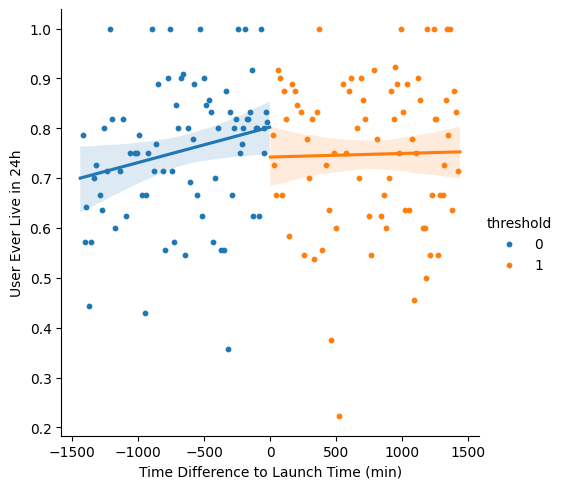

In [397]:
sns.lmplot(data=rdd_df_amed3, x="running_var", y="ever_live_24h", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("User Ever Live in 24h")


Text(39.30079566936729, 0.5, 'User Ever Live in 24h')

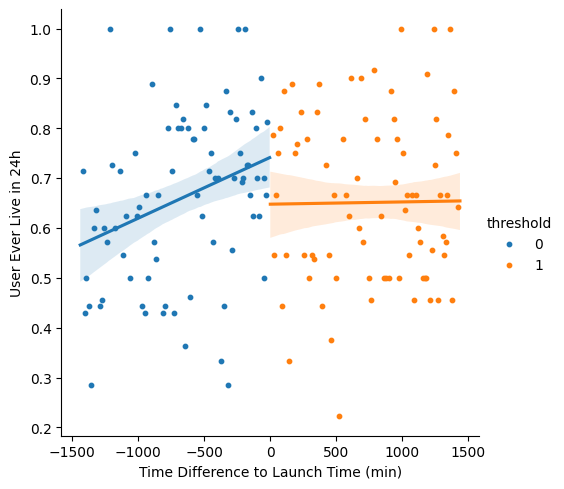

In [398]:
sns.lmplot(data=rdd_df_amed3, x="running_var", y="ever_live_12h", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("User Ever Live in 24h")

Text(39.30079566936729, 0.5, 'User Successifully Matched in 24h')

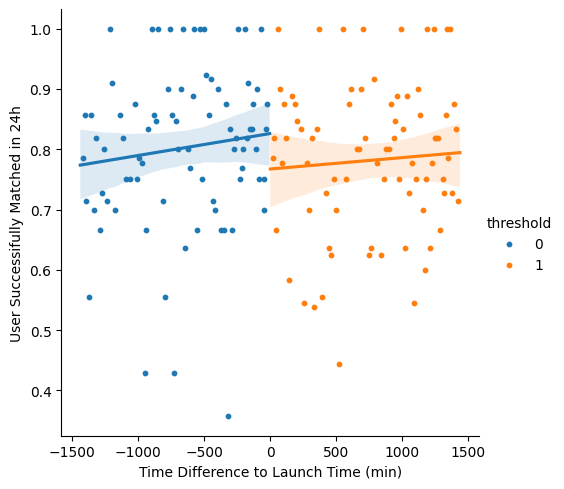

In [399]:
sns.lmplot(data=rdd_df_amed3, x="running_var", y="match_success_24h", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("User Successifully Matched in 24h")

Text(39.30079566936729, 0.5, 'User Successifully Matched in 24h')

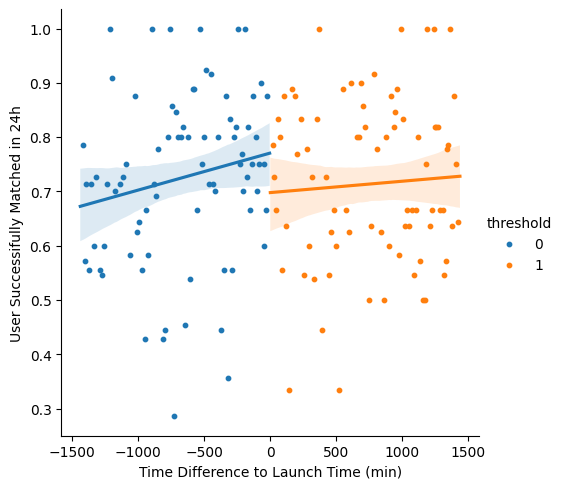

In [400]:
sns.lmplot(data=rdd_df_amed3, x="running_var", y="match_success_12h", hue="threshold", x_bins = 80, x_ci = None, scatter_kws={"s": 10})
plt.xlabel("Time Difference to Launch Time (min)")
plt.ylabel("User Successifully Matched in 24h")

<ipython-input-401-f84b3bfaec12>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['alfredcam_click'] = test['alfredcam_click'].astype(int)


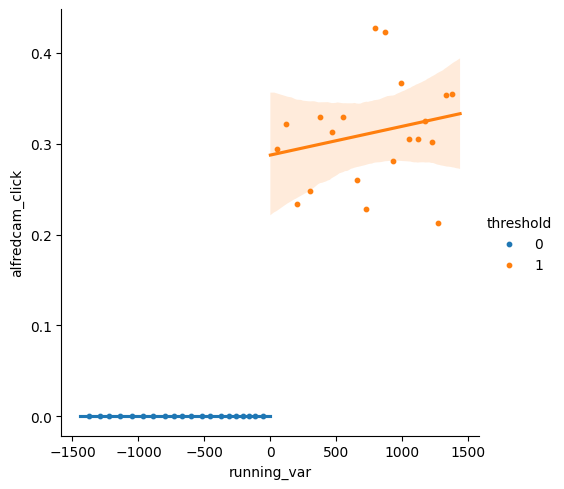

In [401]:
test = rdd_df_amed[~(rdd_df_amed['alfredcam_click'].isnull())]
test['alfredcam_click'] = test['alfredcam_click'].astype(int)
sns.lmplot(data = test, x="running_var", y="alfredcam_click", hue="threshold", x_bins = 20, x_ci = None, scatter_kws={"s": 10})

In [402]:
test

,UId,usage_purpose,location,lang,country,FirstPlatform,FirstVersion,FirstPlatformViewer,FirstVersionViewer,reg_time,TimeFirstLive,TimeFirstLive_s,TimeFirstSubscribe,click,Platform,first_show_time,second_show_time,SessionId,second_show_sid,click_time,two_show_gap,time_stay_on_page,f0_,slc_30m_rev,last_online,mobile_click,alfredcam_click,web_click,set_later_click,slc_30m_scv,clc_30m_clcs,time_account_first_multi,mat_compl,mobile_click_1d,alfredcam_click_1d,web_click_1d,set_later_click_1d,clc_1d_clcs,pla_ANDROID,pla_IOS,cty_TW,cty_US,lan_ar,lan_de,lan_el,lan_en,lan_en-US,lan_en_US,lan_es,lan_fa,lan_fr,lan_gu,lan_ha,lan_he,lan_hi,lan_id,lan_in,lan_it,lan_iw,lan_ja,lan_kk,lan_ko,lan_ms,lan_my,lan_nl,lan_pt,lan_ru,lan_sq,lan_th,lan_tr,lan_uk,lan_uz,lan_vi,lan_zh,uap_B&K,uap_Home,uap_Mix B&K,uap_Mix HB&K,uap_Mix HP,uap_Mix Home,uap_Mix Other,uap_Mix PB&K,uap_Mix Pet,uap_Other,uap_Pet,uap_Unknown,clo_baby_room,clo_back_door,clo_bedroom,clo_driveway,clo_front_door,clo_garage,clo_kitchen,clo_living_room,clo_office,clo_store,clo_street,clo_yard,ver_2022_12_1,ver_2022_13_0,mul,mul2,running_var,cli_add_alfredcam,cli_add_mobile_device,cli_add_web_camera,cli_camera_list,cli_explore,cli_mobile_device,cli_more,cli_no_camera_yet_add_camera,cli_premium,cli_set_later,cli_switch_role,cli_web_camera,threshold,interact,click_time_diff
1,000a9225,Home,[],en,US,ANDROID,2022.12.1,ANDROID,2022.12.1,2022-08-24 00:04:06,2022-08-24 14:01:17.408,2022-08-24 14:01:07.464013,NaT,set_later,ANDROID,2022-08-24 00:04:20.883001,2022-08-24 00:04:33.486006,1661299168,1661299168,2022-08-24 00:04:30.012002,0-0 0 0:0:12.603005,0-0 0 0:0:9.129001,true,2,2022-08-27 03:14:27.731001,0,0,0,1,4,2,NaT,2022-08-24 14:00:43.300002,0,0,0,1,21,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,-316.0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.0,9.129001
4,001cc0df,B&K,[],en,US,ANDROID,2022.12.1,ANDROID,2022.12.1,2022-08-23 22:26:51,NaT,NaT,NaT,add_mobile_device,ANDROID,2022-08-23 22:27:03.898001,2022-08-23 22:27:43.706007,1661293588,1661293588,2022-08-23 22:27:07.121002,0-0 0 0:0:39.808006,0-0 0 0:0:3.223001,NaN,2,NaT,1,0,0,0,5,1,NaT,NaT,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-413.0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.0,3.223001
10,0029fe6d,Home,[bedroom],en,US,ANDROID,2022.12.1,ANDROID,2022.12.1,2022-08-24 22:29:00,2022-09-24 03:53:30.639,NaT,NaT,add_mobile_device,ANDROID,2022-08-24 22:29:10.122001,NaT,1661380130,NaN,2022-08-24 22:29:40.080001,NaN,0-0 0 0:0:29.958,true,1,NaT,1,0,0,0,5,2,NaT,NaT,1,0,0,0,2,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1029.0,0,1,0,0,0,0,0,0,0,0,0,0,1,1029.0,29.958000
12,003201bb,Home,[],en,US,IOS,2022.12.1,IOS,2022.12.1,2022-08-23 13:48:54,2022-08-25 18:23:31.000,2022-08-25 18:23:26.739001,NaT,add_mobile_device,IOS,2022-08-23 13:49:04.358007,NaT,1661262360,NaN,2022-08-23 13:49:08.016008,NaN,0-0 0 0:0:3.658001,NaN,1,2022-08-25 18:19:14.367001,1,0,0,0,28,4,NaT,2022-08-23 13:50:03.182001,1,0,0,0,9,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-931.0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.0,3.658001
23,00426db3,Unknown,[],en,US,ANDROID,2022.12.1,ANDROID,2022.12.1,2022-08-24 14:29:12,NaT,NaT,NaT,set_later,ANDROID,2022-08-24 14:29:33.385001,NaT,1661351329,NaN,2022-08-24 14:30:05.573004,NaN,0-0 0 0:0:32.188003,NaN,1,NaT,0,0,0,1,8,1,NaT,NaT,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,550.0,0,0,0,0,0,0,0,0,0,1,0,0,1,550.0,32.188003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...